In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append("../core")
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord
from scipy.interpolate import RegularGridInterpolator, splrep, splev, InterpolatedUnivariateSpline
from scipy.stats import chi2, gaussian_kde, norm
from scipy.special import erfinv, erf
from scipy.optimize import fmin_l_bfgs_b
from copy import deepcopy
import healpy as hp
import gc
gc.enable()
from settings import *
from tools import get_mids, energy_smearing

In [3]:
print(LIVETIME)
print(GAMMA_ASTRO)
print(PHI_ASTRO)

315567360.0
2.28
1.44e-18


# Get the effective areas based on "alternative_plenum_aeff.ipynb"

We use here only upgoing events with dec>-5deg, since this is the threshold for a pure data set with few muons.

In [4]:
# use only upgoing data to mimick up-going muon track data set
with open("../resources/tabulated_logE_sindec_aeff_upgoing.pckl", "rb") as f:
    log_ebins, sindec_bins, aeff_2d = pickle.load(f)

log_emids = get_mids(log_ebins)
ebins = np.power(10, log_ebins)
emids = get_mids(ebins)
ewidth = np.diff(ebins)

sindec_mids = get_mids(sindec_bins)
sindec_width = np.diff(sindec_bins)

ra_bins = np.linspace(0, np.pi*2, num=101)
ra_mids = (ra_bins[1:] + ra_bins[:-1]) * 0.5
ra_width = ra_bins[1:] - ra_bins[:-1]
print(len(emids), "log_10(energy) bins")
print(len(sindec_mids), "declination bins")

40 log_10(energy) bins
50 declination bins


### here, we use "Plenum-1" with 10yr IceCube and 10yr PLENUM with IceCube
= baseline PLENUM + 10yr IceCube
### and "Plenum-2" with 10yr IceCube and 10yr PLENUM with GEN2
= baseline PLENUM (includes 10yr IceCube) + 10yr GEN2


### background

In [5]:
# MCEQ
with open("../resources/MCEq_flux.pckl", "rb") as f:
    (e_grid, zen), flux_def = pickle.load(f)
rgi = RegularGridInterpolator(
    (e_grid, -np.cos(np.deg2rad(zen))), 
    np.log(flux_def['numu_conv'])
)
ee, ss = np.meshgrid(emids, sindec_mids)
spl_vals = np.exp(rgi((ee, ss)))

## Icecube energy x sindec
### comparison to diffuse (only northern) should yield ~600k events, ~2700 astro for a livetime of 10 years

In [6]:
from aeff_calculations import aeff_eval_e_sd

In [8]:
# check
for det in ["IceCube", "Plenum-1"]:
    aeff_factor = aeff_eval_e_sd(aeff_2d[det], sindec_width, ewidth, ra_width) * LIVETIME
    astro_ev = aeff_factor * (emids/E_NORM)**(-GAMMA_ASTRO) * PHI_ASTRO
    atm_ev = aeff_factor * spl_vals

    print(det)
    print("conv events:", np.sum(atm_ev))
    print("astro events:", np.sum(astro_ev))

IceCube
conv events: 673755.3335225435
astro events: 2338.175466619447
Plenum-1
conv events: 2711814.507173375
astro events: 9348.838357107259


# energy smearing with KDE

In [10]:
with open("../resources/energy_smearing_kde.pckl", "rb") as f:
    kvals = pickle.load(f)
# normalize per bin in true energy
normed_kvals = kvals/np.sum(kvals, axis=0)

eri = get_mids(np.arange(0.5, 9, 0.2))
# log_emids are the same as for effective area binning
ee, rr = np.meshgrid(log_emids, eri)

Text(0.5, 0, 'log(E true (neutrino) / GeV)')

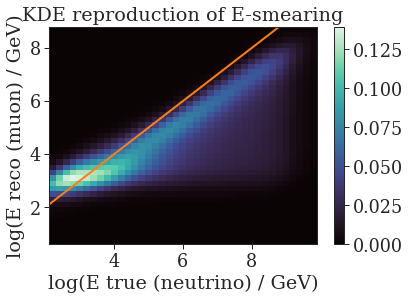

In [11]:
plt.pcolormesh(
    ee,
    rr,
    kvals
)
plt.colorbar()
plt.plot([1, 9], [1, 9], color="tab:orange")
plt.ylim(np.min(rr), np.max(rr))
plt.xlim(np.min(ee), np.max(ee))
plt.title("KDE reproduction of E-smearing")
plt.ylabel("log(E reco (muon) / GeV)")
plt.xlabel("log(E true (neutrino) / GeV)")

### nice plot of expected astro events with energy smearing

Text(0, 0.5, '$\\sin(\\delta)$')

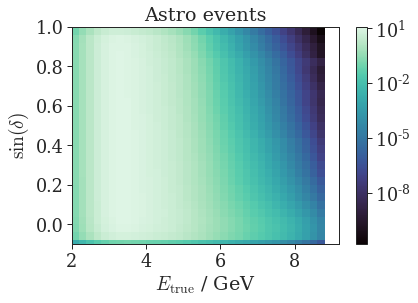

In [12]:
aeff_factor = aeff_eval_e_sd(
    aeff_2d["IceCube"],
    sindec_width, ewidth, ra_width) * LIVETIME
astro_ev = energy_smearing(
    normed_kvals,
    aeff_factor * (emids/E_NORM)**(-GAMMA_ASTRO) * PHI_ASTRO)

f, ax = plt.subplots()
im = ax.pcolormesh(
    eri,
    sindec_bins,
    astro_ev,
    norm=LogNorm()
)
plt.colorbar(im, ax=ax)
ax.set_ylim(-0.1, 1)
ax.set_xlim(2, 9.2)
ax.set_title("Astro events")
ax.set_xlabel(r"$E_{\rm true}$ / GeV")
ax.set_ylabel(r"$\sin(\delta)$")

## test event numbers

In [13]:
aeff_factor = aeff_eval_e_sd(
    aeff_2d["IceCube"],
    sindec_width, ewidth, ra_width) * LIVETIME
astro_ev = aeff_factor * (emids/E_NORM)**(-GAMMA_ASTRO) * PHI_ASTRO

print("original sum astro:", np.sum(astro_ev))
print("smeared sum astro:", np.sum(energy_smearing(normed_kvals, astro_ev)), "(should be numerically the same)")

original sum astro: 2338.175466619447
smeared sum astro: 2338.1754666194474 (should be numerically the same)


## Simple diffuse flux fit

### adapted from mauricio's notebook

In [12]:
## Adapted from Mauricio's fluxes
#### to be moved to separate script

# These are the basic shapes
def gaussian(x, mu, sigma):
    '''Not normalized, then parameters are easier to interpret'''
    return np.exp(-(x - mu)**2 / (2 * sigma**2) ) #/(np.sqrt(2*np.pi) * sigma)

def power_law(energy, e_scale, gamma, phi0):
    return (energy/e_scale)**(-gamma) * phi0

def cut_off(energy, e_cut):
    return np.exp(-energy/e_cut)

def parabola_index(alpha, beta, energy, enorm):
    return alpha + beta * np.log10(energy/enorm)

def sigmoid(fraction_depletion, growth_rate, energy, energy_nu_trans):
    factor = 1 - fraction_depletion
    factor /= (1 + np.exp(-growth_rate * (energy - energy_nu_trans)))
    factor += fraction_depletion
    return factor

# combine basic shapes to actual fluxes

def astro_flux(shape, aeff_factor, emids, enorm, *args, smear_energy=True):
    """ 
    Wrapper for different astro flux shapes to put into TS minimizer.
    Possible shapes and their parameters:
    ° powerlaw:
        args[0]: gamma
        args[1]: phi scaling
    
    ° double powerlaw:
        args[0]: gamma_1 (E < E_Break)
        args[1]: phi scaling
        args[2]: gamma_2 (E >= E_Break)
        args[3]: E_Break
        
    ° powerlaw * cutoff:
        args[0]: gamma
        args[1]: phi scaling
        args[2]: cutoff energy
        
    ° powerlaw * dip/bump:
        args[0]: gamma
        args[1]: phi scaling
        args[2]: amplitude --- sign of amplitude is defined by 'dip' or 'bump'
        args[3]: mean energy
        args[4]: width
        
    ° powerlaw * sigmoid:
        args[0]: gamma
        args[1]: phi scaling
        args[2]: fraction of depletion
        args[3]: growth rate
        args[4]: transition energy
        
    ° log-parabola:
        args[0]: alpha parameter
        args[1]: phi scaling
        args[2]: beta parameter
    """
    if "powerlaw" in shape:
        _gamma_astro = args[0]
        _phi_astro_scaling = args[1]
        tmp =  aeff_factor * power_law(
            emids, enorm, _gamma_astro, PHI_0 * _phi_astro_scaling)
        
    if "double" in shape:
        _gamma_2 = args[2]
        _E_break = np.power(10, args[3])
        phi_2 = PHI_0 * _phi_astro_scaling * (_E_break / enorm) ** (-_gamma_astro + _gamma_2)
        tmp_2 = aeff_factor * power_law(emids, enorm, _gamma_2, phi_2)
        ### merge the two powerlaw shapes
        if type(tmp) == np.ndarray or type(tmp) == list:
            tmp[:,emids >= _E_break] = tmp_2[:,emids >= _E_break]
        elif type(tmp) == float:
            if emids >= _E_break:
                tmp = tmp_2
        else:
            raise ValueError(f"??? invalid type of tmp array ({type(tmp)})")
            
        
    if "cutoff" in shape:
        _energy_cut = np.power(10, args[2])
        tmp *= cut_off(emids, _energy_cut)
        
    if "bump" in shape or "dip" in shape:
        amp = np.power(10, args[2])
        energy_mean = np.power(10, args[3])
        sigma = np.power(10, args[4])
        amp = amp if "bump" in shape else -1 * amp
        tmp *= (1.0 + amp * gaussian(emids, energy_mean, sigma))
        
    if "sigmoid" in shape:
        fraction_depletion = np.power(10, args[2])
        growth_rate = np.power(10, args[3])
        energy_nu_trans = np.power(10, args[4])
        tmp *= sigmoid(fraction_depletion, growth_rate, emids, energy_nu_trans)
        
    if "parabola" in shape:
        _alpha_astro = args[0]
        _phi_astro_scaling = args[1]
        _beta_astro = args[2]        
        index = parabola_index(_alpha_astro, _beta_astro, emids, enorm)
        tmp =  aeff_factor * power_law(
            emids, enorm, index, PHI_0 * _phi_astro_scaling)
    ## energy smearing
    if smear_energy:
        tmp = energy_smearing(normed_kvals, tmp)
    return tmp

In [13]:
def atmo_background(aeff_factor, spl_vals, smear_energy=True):
    if smear_energy:
        return energy_smearing(normed_kvals, aeff_factor * spl_vals)
    else:
        return aeff_factor * spl_vals

In [14]:
#### to be moved to separate script

shape_params = {
    # parameters from https://arxiv.org/abs/1908.09551
    "powerlaw": {
        "baseline": np.array([1, GAMMA_ASTRO, PHI_ASTRO_FACTOR]),
        "bounds": np.array([(0.9, 1.1), (1.0, 4.0), (0.2, 3.0)]),
        "names": np.array(["conv_scaling", "gamma_astro", "Phi_0"]),
        "fancy_names": np.array(["Conv. scaling", r"$\gamma_{\rm astro}$", r"$\Phi_0 /({\rm 10^{-18} GeV cm^2 s sr})$"])
    },
    # parameters inspired by https://www.institut3b.physik.rwth-aachen.de/global/show_document.asp?id=aaaaaaaaawyqakk
    "powerlaw with cutoff": {
        "baseline": np.array([1, 2.0, 1.5, 6]),
        "bounds": np.array([(0.9, 1.1), (1.0, 4.0), (0.2, 3.0), (4.5, 8.5)]),
        "names": np.array(["conv_scaling", "gamma_astro", "Phi_0", "Cut_off"]),
        "fancy_names": np.array(["Conv. scaling", r"$\gamma_{\rm astro}$", r"$\Phi_0 /({\rm 10^{-18} GeV cm^2 s sr})$",
                  r"$\log_{10}$(Cut-off energy/GeV)"])
    },
    # parameters inspired by https://www.institut3b.physik.rwth-aachen.de/global/show_document.asp?id=aaaaaaaaawyqakk
    "log-parabola": {
        "baseline": np.array([1, 2, 1.7, 0.5]),
        "bounds": np.array([(0.9, 1.1), (1.0, 4.0), (0.2, 3.0), (0.1, 1.9)]),
        "names": np.array(["conv_scaling", "alpha", "Phi_0", r"beta"]),
        "fancy_names": np.array(["Conv. scaling", r"$\alpha$", r"$\Phi_0 /({\rm 10^{-18} GeV cm^2 s sr})$", r"$\beta$"])
    },
    # parameters inspired by https://www.institut3b.physik.rwth-aachen.de/global/show_document.asp?id=aaaaaaaaawyqakk
    "double powerlaw": {
        "baseline": np.array([1, 2.0, 1.2, 3.5, np.log10(1E6)]),
        "bounds": np.array([(0.9, 1.1), (1.0, 4.0), (0.2, 3.0), (1.5, 4.0), (5, 7)]),
        "names": np.array(["conv_scaling", "gamma_astro", "Phi_0", "gamma_2", "E_break"]),
        "fancy_names": np.array(["Conv. scaling", r"$\gamma_1$", r"$\Phi_0 /({\rm 10^{-18} GeV cm^2 s sr})$"
                                r"$\gamma_2$", r"$E_{\rm break}$"])
    },
    "powerlaw with sigmoid": {
        "baseline": np.array([1, GAMMA_ASTRO, PHI_ASTRO_FACTOR, np.log10(0.1), np.log10(1E-5), np.log10(4E5)]),
        "bounds": np.array([(0.9, 1.1), (1.0, 4.0), (0.2, 3.0), (-2., 0), (-6, -4), (4.5, 6.5)]),
        "names": np.array(["conv_scaling", "gamma_astro", "Phi_0", "depletion", "growth", "transition"]),
        "fancy_names": np.array(["Conv. scaling", r"$\gamma_{\rm astro}$", r"$\Phi_0 /({\rm 10^{-18} GeV cm^2 s sr})$",
                  "Depletion fraction", "Growth rate", r"$\log_{10}$(Transition energy/GeV)"])
    },
    "powerlaw with dip": {
        "baseline": np.array([1, GAMMA_ASTRO, PHI_ASTRO_FACTOR, np.log10(0.7), np.log10(6E5), np.log10(6E5/3)]),
        "bounds": np.array([(0.9, 1.1), (1.0, 4.0), (0.2, 3.0), (-2., 1), (4., 7.), (3.5, 7.)]),
        "names":np.array(["conv_scaling", "gamma_astro", "Phi_0", "amplitude", "mean_energy", "width"]),
        "fancy_names":np.array(["Conv. scaling", r"$\gamma_{\rm astro}$", r"$\Phi_0 /({\rm 10^{-18} GeV cm^2 s sr})$",
                  "Amplitude", r"$\log_{10}$(Mean energy/GeV)", r"$\log_{10}$(Width/GeV)"])
    },
    "powerlaw with bump": {
        "baseline": np.array([1, GAMMA_ASTRO, PHI_ASTRO_FACTOR, np.log10(2.2), np.log10(4.5E5), np.log10(4.5E5/3)]),
        "bounds": np.array([(0.9, 1.1), (1.0, 4.0), (0.2, 3.0), (-2., 1), (4., 7.), (3.5, 7.)]),
        "names":np.array(["conv_scaling", "gamma_astro", "Phi_0", "amplitude", "mean_energy", "width"]),
        "fancy_names":np.array(["Conv. scaling", r"$\gamma_{\rm astro}$", r"$\Phi_0 /({\rm 10^{-18} GeV cm^2 s sr})$",
                  "Amplitude", r"$\log_{10}$(Mean energy/GeV)", r"$\log_{10}$(Width/GeV)"])
    }
}

# some randomization of guessing parameters
rs = np.random.RandomState(seed=667)
for shape in shape_params:
    shape_params[shape]["guess"] = np.copy(shape_params[shape]["baseline"]) \
                * rs.uniform(0.98, 1.02, size=len(shape_params[shape]["baseline"]))
# alternative: give it the truth to supress minimizer errors
#for shape in shape_params:
#    shape_params[shape]["guess"] = deepcopy(shape_params[shape]["baseline"])

In [15]:
def plot_spectrum(energy, events, labels, title, f, ax, **kwargs):
    ls = kwargs.pop("ls", ["-"] * len(events))
    color = kwargs.pop("color", [None] * len(events))
    ylim = kwargs.pop("ylim", (0.1, 3E4))
    xlim = kwargs.pop("xlim", (1.8, 9))
    ylabel = kwargs.pop("ylabel", r"# events")
    xlabel = kwargs.pop("xlabel", r"$E_{\mu \, \rm reco}$/GeV")
    
    for i, (ev, lab) in enumerate(zip(events, labels)):
        ax.plot(
            energy, ev, drawstyle="steps-mid", label=lab, 
            ls=ls[i],
            color=color[i],
        )
    ax.legend()
    ax.set_title(title)
    ax.set_yscale("log")
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    f.tight_layout()
    return f, ax

#### plot exemplary shapes

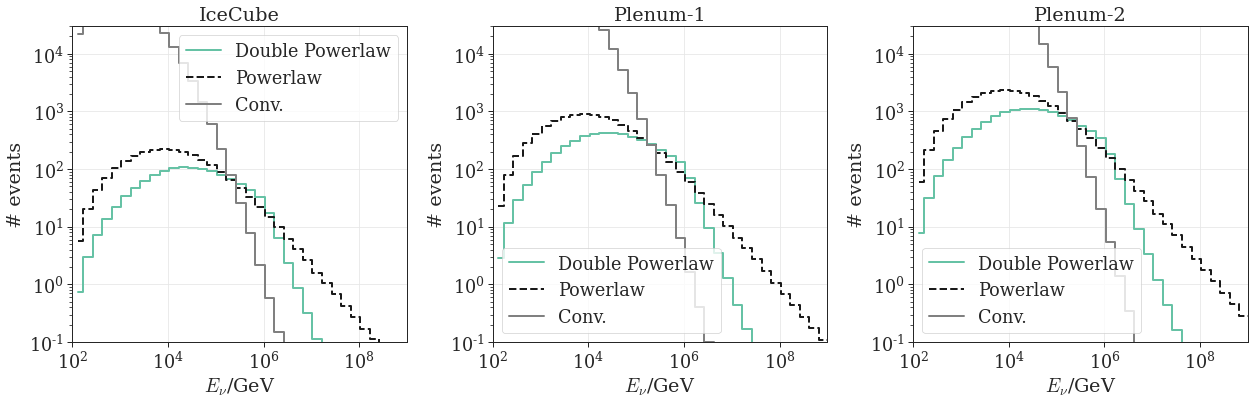

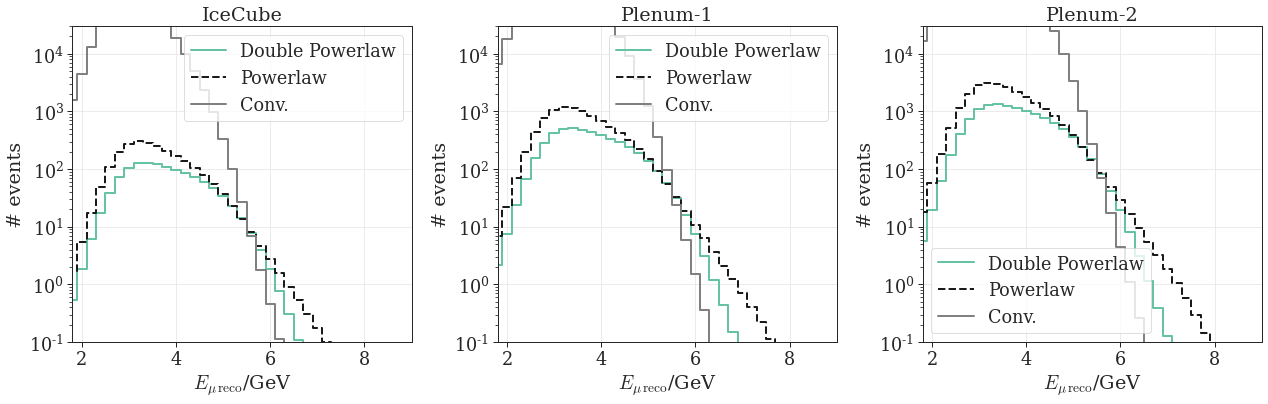

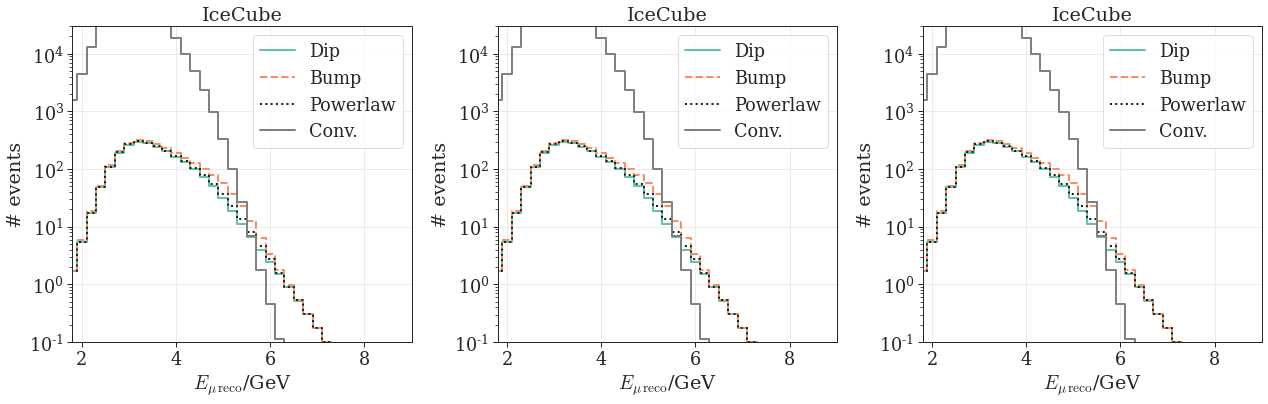

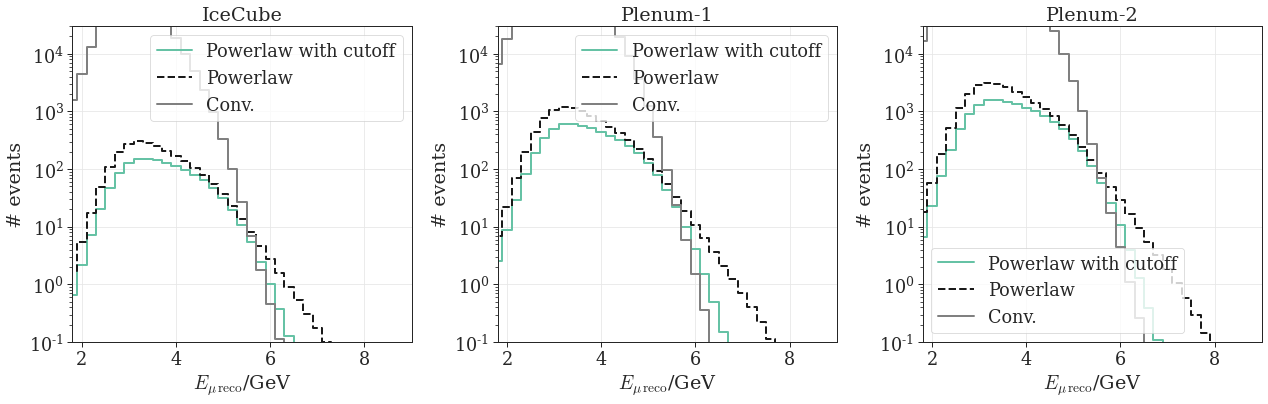

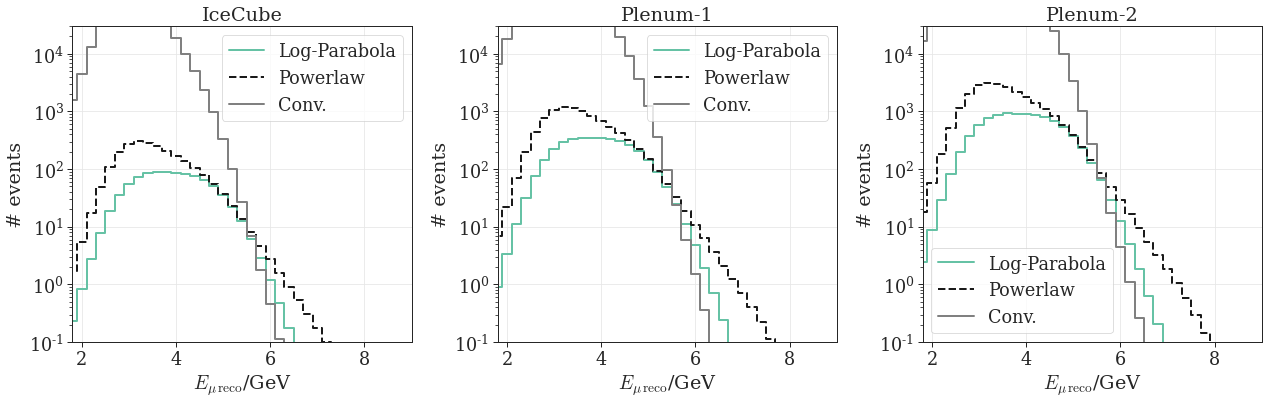

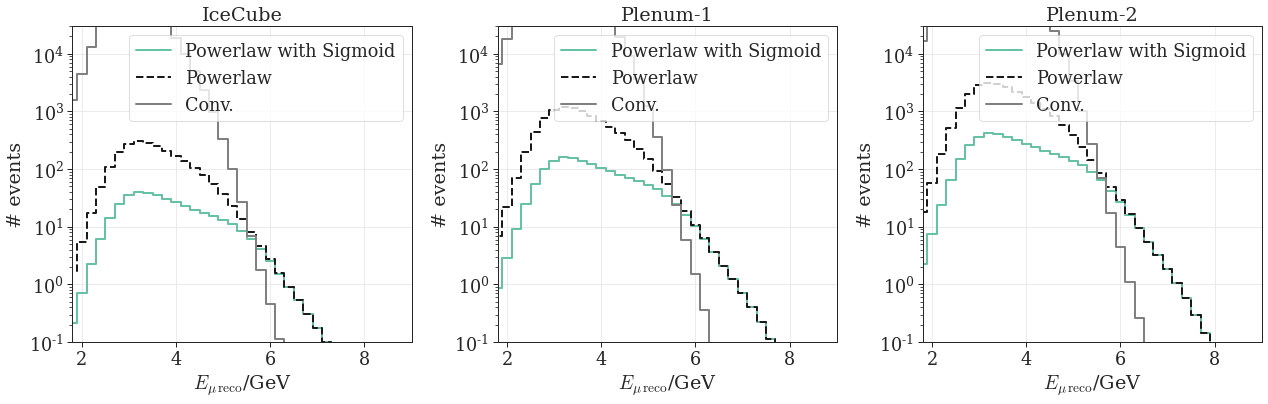

In [16]:
### true energy
idents = ["IceCube", "Plenum-1", "Plenum-2"]
f, axes = plt.subplots(ncols=3, figsize=(18, 6))
for i, ident in enumerate(idents):
    ax = axes[i]
    aeff_factor = aeff_eval_e_sd(aeff_2d[ident]) * LIVETIME    
    events = [
        np.sum(astro_flux(
            "double powerlaw", aeff_factor, emids, E_NORM, smear_energy=False,
            *shape_params["double powerlaw"]["baseline"][1:]), axis=0),
        np.sum(astro_flux(
            "powerlaw", aeff_factor, emids, E_NORM, smear_energy=False,
            *shape_params["powerlaw"]["baseline"][1:]), axis=0),
        np.sum(atmo_background(aeff_factor, spl_vals, smear_energy=False), axis=0)
    ]
    plot_labels = ["Double Powerlaw", "Powerlaw", "Conv."]
    ls = ["-", "--", "-"]
    color = [None, "k", "gray"]
    f, ax = plot_spectrum(
        emids, events, plot_labels, title=ident, f=f, ax=ax,
        ls=ls, color=color, xlabel=r"$E_{\nu}$/GeV", xlim=(1E2, 1E9))
    ax.set_xscale("log")
plt.show()

## reco energy
idents = ["IceCube", "Plenum-1", "Plenum-2"]
f, axes = plt.subplots(ncols=3, figsize=(18, 6))
for i, ident in enumerate(idents):
    ax = axes[i]
    aeff_factor = aeff_eval_e_sd(aeff_2d[ident]) * LIVETIME    
    events = [
        np.sum(astro_flux("double powerlaw", aeff_factor, emids, E_NORM, *shape_params["double powerlaw"]["baseline"][1:]), axis=0),
        np.sum(astro_flux("powerlaw", aeff_factor, emids, E_NORM, *shape_params["powerlaw"]["baseline"][1:]), axis=0),
        np.sum(atmo_background(aeff_factor, spl_vals), axis=0)
    ]
    plot_labels = ["Double Powerlaw", "Powerlaw", "Conv."]
    ls = ["-", "--", "-"]
    color = [None, "k", "gray"]
    plot_spectrum(eri, events, plot_labels, title=ident, f=f, ax=ax, ls=ls, color=color)
plt.show()

#### to be moved to separate script
idents = ["IceCube", "Plenum-1", "Plenum-2"]
f, axes = plt.subplots(ncols=3, figsize=(18, 6))
for i, ident in enumerate(idents):
    ax = axes[i]
    ident = label.split(" ")[-1]
    aeff_factor = aeff_eval_e_sd(aeff_2d[ident]) * LIVETIME
    events = [
        np.sum(astro_flux("powerlaw with dip", aeff_factor, emids, E_NORM, *shape_params["powerlaw with dip"]["baseline"][1:]), axis=0),
        np.sum(astro_flux("powerlaw with bump", aeff_factor, emids, E_NORM, *shape_params["powerlaw with bump"]["baseline"][1:]), axis=0),
        np.sum(astro_flux("powerlaw", aeff_factor, emids, E_NORM, *shape_params["powerlaw"]["baseline"][1:]), axis=0),
        np.sum(atmo_background(aeff_factor, spl_vals), axis=0)
    ]
    plot_labels = ["Dip", "Bump", "Powerlaw", "Conv."]
    ls = ["-", "--", ":", "-"]
    color = [None, None, "k", "gray"]
    plot_spectrum(eri, events, plot_labels, title=ident, f=f, ax=ax, ls=ls, color=color)
    
plt.show()

idents = ["IceCube", "Plenum-1", "Plenum-2"]
f, axes = plt.subplots(ncols=3, figsize=(18, 6))
for i, ident in enumerate(idents):
    ax = axes[i]
    aeff_factor = aeff_eval_e_sd(aeff_2d[ident]) * LIVETIME    
    events = [
        np.sum(astro_flux("powerlaw cutoff", aeff_factor, emids, E_NORM, *shape_params["powerlaw with cutoff"]["baseline"][1:]), axis=0),
        np.sum(astro_flux("powerlaw", aeff_factor, emids, E_NORM, *shape_params["powerlaw"]["baseline"][1:]), axis=0),
        np.sum(atmo_background(aeff_factor, spl_vals), axis=0)
    ]
    plot_labels = ["Powerlaw with cutoff", "Powerlaw", "Conv."]
    ls = ["-", "--", "-"]
    color = [None, "k", "gray"]
    plot_spectrum(eri, events, plot_labels, title=ident, f=f, ax=ax, ls=ls, color=color)
plt.show()

idents = ["IceCube", "Plenum-1", "Plenum-2"]
f, axes = plt.subplots(ncols=3, figsize=(18, 6))
for i, ident in enumerate(idents):
    ax = axes[i]
    aeff_factor = aeff_eval_e_sd(aeff_2d[ident]) * LIVETIME    
    events = [
        np.sum(astro_flux("log-parabola", aeff_factor, emids, E_NORM, *shape_params["log-parabola"]["baseline"][1:]), axis=0),
        np.sum(astro_flux("powerlaw", aeff_factor, emids, E_NORM, *shape_params["powerlaw"]["baseline"][1:]), axis=0),
        np.sum(atmo_background(aeff_factor, spl_vals), axis=0)
    ]
    plot_labels = ["Log-Parabola", "Powerlaw", "Conv."]
    ls = ["-", "--", "-"]
    color = [None, "k", "gray"]
    plot_spectrum(eri, events, plot_labels, title=ident, f=f, ax=ax, ls=ls, color=color)
plt.show()

idents = ["IceCube", "Plenum-1", "Plenum-2"]
f, axes = plt.subplots(ncols=3, figsize=(18, 6))
for i, ident in enumerate(idents):
    ax = axes[i]
    aeff_factor = aeff_eval_e_sd(aeff_2d[ident]) * LIVETIME    
    events = [
        np.sum(astro_flux("powerlaw with sigmoid", aeff_factor, emids, E_NORM, *shape_params["powerlaw with sigmoid"]["baseline"][1:]), axis=0),
        np.sum(astro_flux("powerlaw", aeff_factor, emids, E_NORM, *shape_params["powerlaw"]["baseline"][1:]), axis=0),
        np.sum(atmo_background(aeff_factor, spl_vals), axis=0)
    ]
    plot_labels = ["Powerlaw with Sigmoid", "Powerlaw", "Conv."]
    ls = ["-", "--", "-"]
    color = [None, "k", "gray"]
    plot_spectrum(eri, events, plot_labels, title=ident, f=f, ax=ax, ls=ls, color=color)
plt.show()

# Define likelihood and test statistic

In [17]:
#### to be moved to separate script
def spectral_ts_func(x, aeff_factor, emids, enorm, k_i, shape, verbose=False, **kwargs):
    """First parameter is always conv scaling, rest is defined in astro_flux()"""
    # free parameters
    _conv_scaling = x[0]
    background_spl = kwargs.pop("background_spl", spl_vals)
    # astro events with single powerlaw
    # this is already smeared in energy
    astro_ev = astro_flux(shape, aeff_factor, emids, enorm, *x[1:])
    if verbose:
        print(x)
        print(*x[1:])
        print(np.sum(astro_ev))
    # atm events based on MCEQ with scaling factor
    atm_ev = atmo_background(aeff_factor, background_spl * _conv_scaling)
    # this defines the LLH function with free parameters
    all_mu_i = astro_ev + atm_ev
    return -2 * np.sum(
        np.where(
            all_mu_i > 0,
            k_i * np.log(all_mu_i) - all_mu_i \
                - 0.5 * np.log(2*np.pi*k_i) + k_i - k_i * np.log(k_i),
            0)
    )

In [18]:
#### to be moved to separate script
def local_ts_func(x, fixed_params, free_positions, fixed_params_positions, *args):
    r""" Reduce full likelihood function with fixed parameters, i.e. reduce to
    a 'local' likelihood function. Free and fixed parameters are combined in one
    array to be piped through to 'spectral_ts_func'.
    -----------------------------------------------------------------------
    
    x: free parameters, piped through to 'spectral_ts_func'
    fixed_params: value of fixed parameters
    free_positions: array indices of free parameters
    fixed_params_positions: array indices of fixed parameters
    *args: piped through to 'spectral_ts_func'
    
    returns spectral_ts_func(free_and_fixed_parameters, *args)
    """
    all_x = np.zeros(len(x) + len(fixed_params))
    for i, pos in enumerate(fixed_params_positions):
        all_x[pos] = fixed_params[i]
    for i, pos in enumerate(free_positions):
        all_x[pos] = x[i]
    return spectral_ts_func(all_x, *args)

In [19]:
def asimov_data(aeff_factor, shape_key, verbose=False, **kwargs):
    shp_params = kwargs.pop("shp_params", np.copy(shape_params[shape_key]["baseline"]))
    background_spl = kwargs.pop("background_spl", spl_vals)
    # calculate asimov 'data' = expectation of perfect experiment
    astro_ev = astro_flux(shape_key, aeff_factor, emids, E_NORM, *shp_params[1:])
    if verbose:
        print("baseline astro ev", np.sum(astro_ev))
    atm_ev = atmo_background(aeff_factor, background_spl * shp_params[0])
    # asimov = expectation of perfect experiment
    return astro_ev + atm_ev

## Loop through all shapes and make a spectral fit

In [20]:
idents = ["IceCube", "Plenum-1", "Plenum-2"]
verbose = True
fit_results = {}
for shape in shape_params:
    print(shape)
    fit_results[shape] = {}
    for li, ident in enumerate(idents):
        if verbose: print(ident)
        aeff_factor = aeff_eval_e_sd(aeff_2d[ident], sindec_width, ewidth, ra_width) * LIVETIME
        if "Plenum" in ident:
            aeff_factor += aeff_eval_e_sd(aeff_2d["IceCube"], sindec_width, ewidth, ra_width) * LIVETIME
        # asimov = expectation of perfect experiment
        k_i = asimov_data(aeff_factor, shape, verbose=False)

        # global min
        out = fmin_l_bfgs_b(
            spectral_ts_func,
            x0=shape_params[shape]["guess"],
            bounds=shape_params[shape]["bounds"],
            approx_grad=True,
            args=(aeff_factor, emids, E_NORM, k_i, shape)
        )
        print("shape fit:", out[0])
        fit_results[shape][ident] = out
        if out[2]['warnflag'] != 0:
            print("WARNING!!")
            
        # check that the TS at the fit minimum is close to the TS of the baseline params
        baseline_ts = spectral_ts_func(
            shape_params[shape]["baseline"],
            aeff_factor, emids, E_NORM, k_i, shape
        )
        baseline_ts_check = np.isclose(
            out[1], baseline_ts, rtol=1E-3
        )
        print("TS asimov check:", "OK" if baseline_ts_check else "not OK :(")
        print("fit: ", out[1], ", reference:", baseline_ts)
        # best fit powerlaw as null hypothesis     
        out_pl = fmin_l_bfgs_b(
            spectral_ts_func,
            x0=shape_params["powerlaw"]["guess"],            
            bounds=shape_params["powerlaw"]["bounds"],
            approx_grad=True,
            args=(aeff_factor, emids, E_NORM, k_i, "powerlaw")
        )
        ## be aware: this doesn't tell you whether or not the fit worked
        ## a 2D scan can confirm (see below)
        print("pl fit:", out_pl[0])        
        pval = chi2.sf(out_pl[1] - out[1], 1)
        significance = erfinv(1 - pval) * np.sqrt(2)
        print("P-VALUE:", pval, ", SIGNIFICANCE:", significance)
        if False: #verbose:
            print("asimov baseline param: ", shape_params[shape]["baseline"])
            print("bf param:", fit_results[shape][ident][0])
            print("guess param: ", shape_params[shape]["guess"])
            print("diff (truth vs fit):", shape_params[shape]["baseline"]/ fit_results[shape][ident][0] -1)
            print("* *" * 30)
    print("- -" * 30)

powerlaw
IceCube
shape fit: [0.99998312 2.28084635 1.44437499]
TS asimov check: OK
fit:  817.9557307577493 , reference: 817.9554966807518
pl fit: [0.99998312 2.28084635 1.44437499]
P-VALUE: 1.0 , SIGNIFICANCE: 0.0
Plenum-1
shape fit: [0.9999901  2.28049948 1.44259497]
TS asimov check: OK
fit:  5173.963105151971 , reference: 5173.962659000597
pl fit: [0.9999901  2.28049948 1.44259497]
P-VALUE: 1.0 , SIGNIFICANCE: 0.0
Plenum-2
shape fit: [1.00000067 2.28005729 1.44000316]
TS asimov check: OK
fit:  6322.673119994047 , reference: 6322.673104131961
pl fit: [1.00000067 2.28005729 1.44000316]
P-VALUE: 1.0 , SIGNIFICANCE: 0.0
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
powerlaw with cutoff
IceCube
shape fit: [0.9999941  2.00106637 1.50090314 6.00034456]
TS asimov check: OK
fit:  -1148.7294722167612 , reference: -1148.7294872253683
pl fit: [0.99828846 2.41856605 1.08939337]
P-VALUE: 0.12930263075144388 , SIGNIFICANCE: 1.5168576390547535
Plenum-1
sh

powerlaw


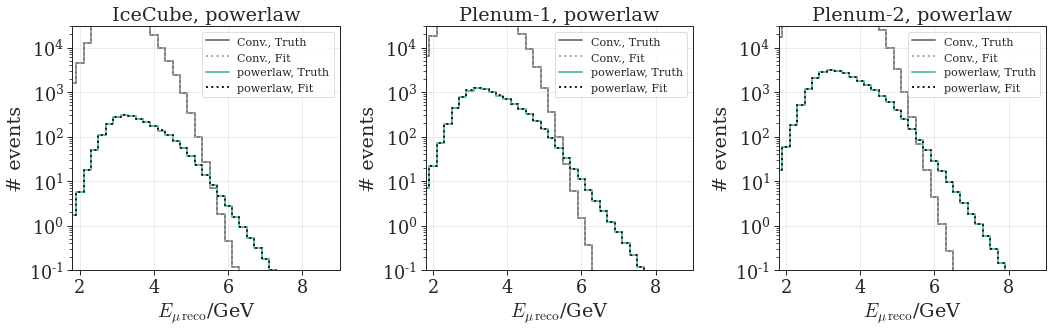

powerlaw with cutoff


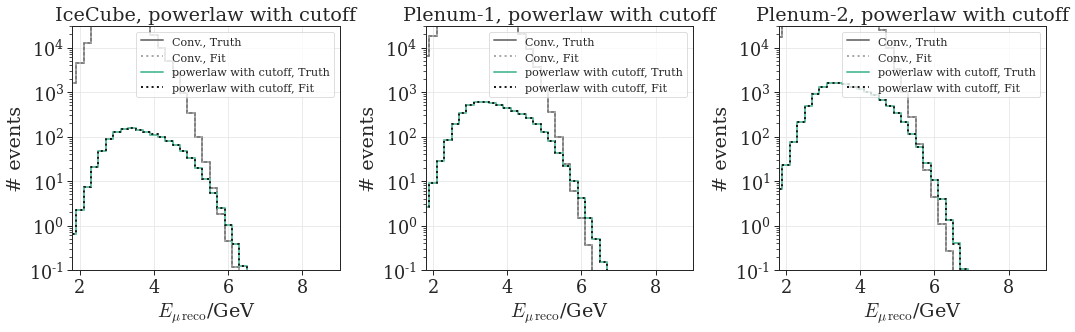

log-parabola


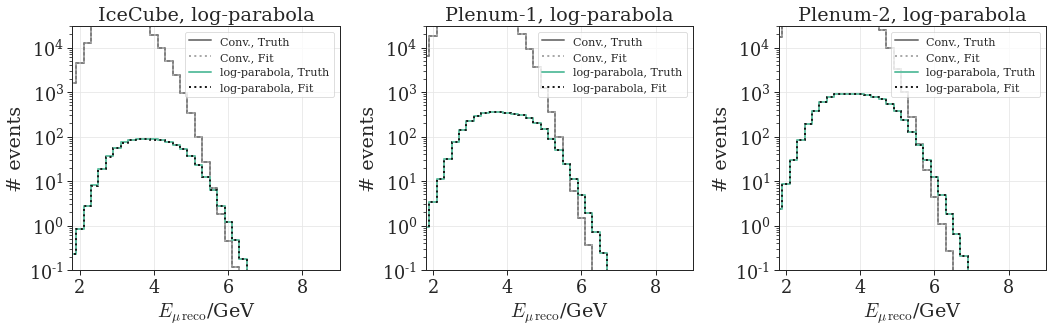

double powerlaw


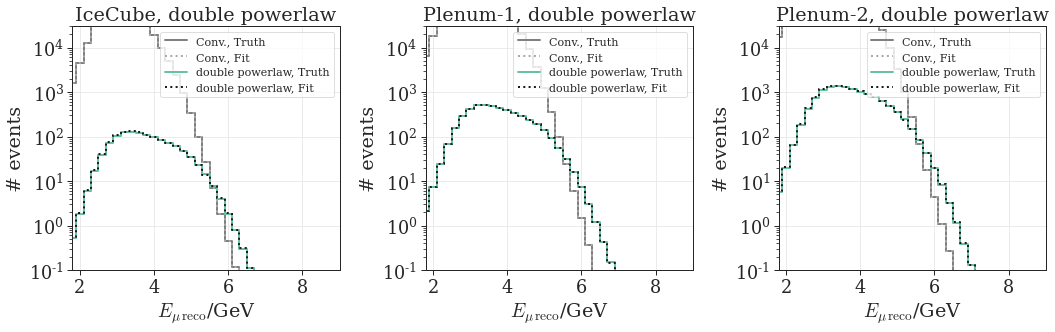

powerlaw with sigmoid


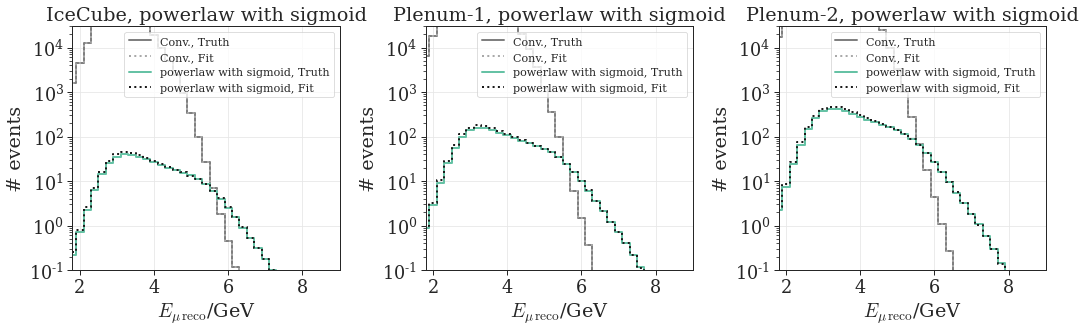

powerlaw with dip


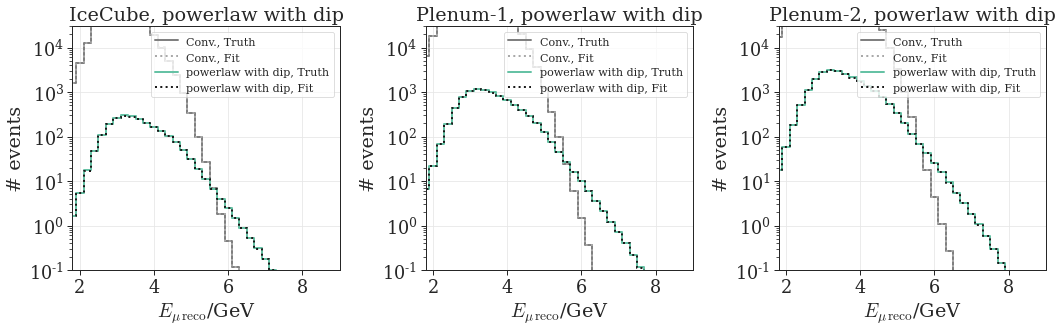

powerlaw with bump


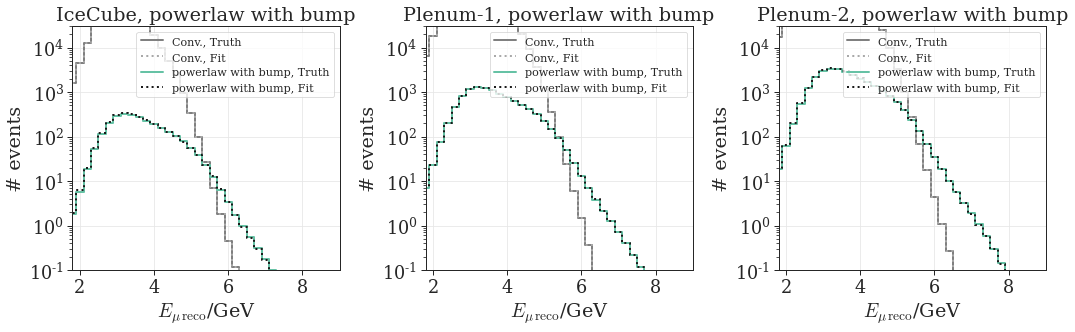

In [21]:
for shape in shape_params:
    print(shape)
    f, axes = plt.subplots(ncols=3, figsize=(15, 5))
    for li, ident in enumerate(idents):
        ax = axes[li]
        aeff_factor = aeff_eval_e_sd(aeff_2d[ident], sindec_width, ewidth, ra_width) * LIVETIME
        events = [
            np.sum(atmo_background(aeff_factor, spl_vals * shape_params[shape]["baseline"][0]), axis=0),
            np.sum(atmo_background(aeff_factor, spl_vals * fit_results[shape][ident][0][0]), axis=0),
            np.sum(astro_flux(shape, aeff_factor, emids, E_NORM, *shape_params[shape]["baseline"][1:]), axis=0),
            np.sum(astro_flux(shape, aeff_factor, emids, E_NORM, *fit_results[shape][ident][0][1:]), axis=0)
        ]
        plot_labels = ["Conv., Truth", "Conv., Fit", shape + ", Truth", shape + ", Fit"]
        ls = ["-", ":", "-", ":"]
        color = ["gray", "darkgray", None, "k"]
        f, ax = plot_spectrum(eri, events, plot_labels, title=ident + ", " + shape, f=f, ax=ax, ls=ls, color=color)        
        ax.legend(fontsize="xx-small", loc=1)
        f.tight_layout()
    plt.show()


## 1D scan powerlaw
Calculate expected parameter uncertainties

In [22]:
idents = ["IceCube", "Plenum-1", "Plenum-2"]
num = 100
gamma_astro_scaling = np.linspace(1.9, 2.7, num=num+1)
astro_scaling = np.linspace(0.4, 2.6, num=num)

In [23]:
bf_SPL = {
    "ts": {},
    "conv": {},
    "gamma": {},
    "phi_astro": {}
}
local_SPL_gamma_scan = {    
    "ts": {},
    "conv": {},
    "phi_astro": {}
}
local_SPL_phi_scan = {    
    "ts": {},
    "conv": {},
    "gamma": {}
}
shape = "powerlaw"
for ident in idents:
    print(ident)
    aeff_factor = aeff_eval_e_sd(aeff_2d[ident], sindec_width, ewidth, ra_width) * LIVETIME
    if "Plenum" in ident:
        aeff_factor += aeff_eval_e_sd(aeff_2d["IceCube"], sindec_width, ewidth, ra_width) * LIVETIME
    # asimov = expectation of perfect experiment
    k_i = asimov_data(
        aeff_factor, 
        shape, 
        verbose=verbose)

    # global min
    out = fmin_l_bfgs_b(
        spectral_ts_func,
        x0=shape_params[shape]["guess"],
        approx_grad=True,
        args=(aeff_factor, emids, E_NORM, k_i, shape)
    )
    if out[2]['warnflag'] != 0:
        print("WARNING!!")
    print("asimov param: ", shape_params[shape]["baseline"])
    print("bf param:", out[0])
    
    bf_SPL["ts"][ident] = out[1]
    bf_SPL["conv"][ident] = out[0][0]
    bf_SPL["gamma"][ident] = out[0][1]
    bf_SPL["phi_astro"][ident] = out[0][2]
    
    local_SPL_gamma_scan["ts"][ident] = np.zeros_like(gamma_astro_scaling)
    local_SPL_gamma_scan["conv"][ident] = np.zeros_like(gamma_astro_scaling)
    local_SPL_gamma_scan["phi_astro"][ident] = np.zeros_like(gamma_astro_scaling)
    print("starting local fits...")
    for j, gas in enumerate(gamma_astro_scaling):
        # local min with fixed phi_astro
        local_out = fmin_l_bfgs_b(
            local_ts_func,
            x0=[1.0, 1.0],
            approx_grad=True,
            args=([gas], (0, 2), (1, ), aeff_factor, emids, E_NORM, k_i, shape)
        )
        local_SPL_gamma_scan["conv"][ident][j], local_SPL_gamma_scan["phi_astro"][ident][j]= local_out[0]
        local_SPL_gamma_scan["ts"][ident][j] = local_out[1]
        
    local_SPL_phi_scan["ts"][ident] = np.zeros_like(astro_scaling)
    local_SPL_phi_scan["conv"][ident] = np.zeros_like(astro_scaling)
    local_SPL_phi_scan["gamma"][ident] = np.zeros_like(astro_scaling)
    print("starting local fits...")
    for j, aas in enumerate(astro_scaling):
        # local min with fixed phi_astro
        local_out = fmin_l_bfgs_b(
            local_ts_func,
            x0=[1.0, 2.2],
            approx_grad=True,
            args=([aas], (0, 1), (2, ), aeff_factor, emids, E_NORM, k_i, shape)
        )
        local_SPL_phi_scan["conv"][ident][j], local_SPL_phi_scan["gamma"][ident][j]= local_out[0]
        local_SPL_phi_scan["ts"][ident][j] = local_out[1]
    print("done")    

IceCube
baseline astro ev 2337.493526416219
asimov param:  [1.   2.28 1.44]
bf param: [1.00001442 2.27924091 1.43637391]
starting local fits...
starting local fits...
done
Plenum-1
baseline astro ev 11685.649943320248
asimov param:  [1.   2.28 1.44]
bf param: [1.00001547 2.27916597 1.43613218]
starting local fits...
starting local fits...
done
Plenum-2
baseline astro ev 26824.99689609896
asimov param:  [1.   2.28 1.44]
bf param: [1.00001457 2.27924365 1.43628113]
starting local fits...
starting local fits...
done


Text(0, 0.5, '-2$\\Delta$LLH')

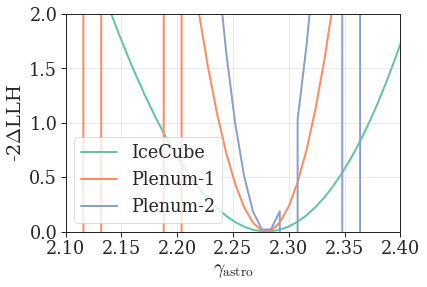

In [24]:
for ident in idents:
    plt.plot(gamma_astro_scaling, local_SPL_gamma_scan["ts"][ident] - bf_SPL["ts"][ident], label=ident)
plt.ylim(0, 2)
plt.xlim(2.1, 2.4)
plt.legend(loc=3)
plt.xlabel(r"$\gamma_{\rm astro}$")
plt.ylabel(r"-2$\Delta$LLH")

Text(0, 0.5, '-2$\\Delta$LLH')

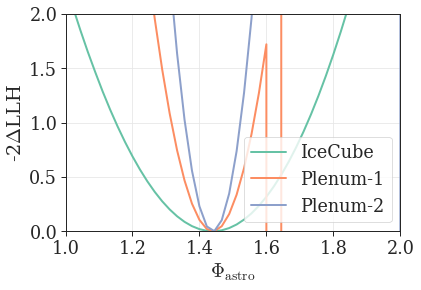

In [25]:
for ident in idents:
    plt.plot(astro_scaling, local_SPL_phi_scan["ts"][ident] - bf_SPL["ts"][ident], label=ident)
plt.ylim(0, 2)
plt.xlim(1, 2)
plt.legend(loc=4)
plt.xlabel(r"$\Phi_{\rm astro}$")
plt.ylabel(r"-2$\Delta$LLH")

## 2D scan powerlaw
Show that we can roughly reproduce the diffuse results from ICRC2019

In [26]:
idents = ["IceCube", "Plenum-1", "Plenum-2"]
num = 50
gamma_astro_scaling = np.linspace(1.9, 2.7, num=num+1)
astro_scaling = np.linspace(0.4, 2.6, num=num)

In [27]:
bf_SPL = {
    "ts": {},
    "conv": {},
    "gamma": {},
    "phi_astro": {}
}
local_SPL = {    
    "ts": {},
    "conv": {}
}

shape = "powerlaw"
for ident in idents:
    print(ident)
    aeff_factor = aeff_eval_e_sd(aeff_2d[ident], sindec_width, ewidth, ra_width) * LIVETIME
    if "Plenum" in ident:
        aeff_factor += aeff_eval_e_sd(aeff_2d["IceCube"], sindec_width, ewidth, ra_width) * LIVETIME
    # asimov = expectation of perfect experiment
    k_i = asimov_data(
        aeff_factor, 
        shape, 
        verbose=verbose)

    # global min
    out = fmin_l_bfgs_b(
        spectral_ts_func,
        x0=shape_params[shape]["guess"],
        approx_grad=True,
        args=(aeff_factor, emids, E_NORM, k_i, shape)
    )
    if out[2]['warnflag'] != 0:
        print("WARNING!!")
    print("asimov param: ", shape_params[shape]["baseline"])
    print("bf param:", out[0])
    
    bf_SPL["ts"][ident] = out[1]
    bf_SPL["conv"][ident] = out[0][0]
    bf_SPL["gamma"][ident] = out[0][1]
    bf_SPL["phi_astro"][ident] = out[0][2]
    
    local_SPL["ts"][ident] = np.zeros((num, num+1))
    local_SPL["conv"][ident] = np.zeros((num, num+1))
    print("starting local fits...")
    for i, asc in enumerate(astro_scaling):
        for j, gas in enumerate(gamma_astro_scaling):
            # local min with fixed phi_astro
            local_out = fmin_l_bfgs_b(
                local_ts_func,
                x0=[1.1],
                approx_grad=True,
                args=([gas, asc], (0, ), (1, 2), aeff_factor, emids, E_NORM, k_i, shape)
            )
            local_SPL["conv"][ident][i][j], = local_out[0]
            local_SPL["ts"][ident][i][j] = local_out[1]
    print("done")    

IceCube
baseline astro ev 2337.493526416219
asimov param:  [1.   2.28 1.44]
bf param: [1.00001442 2.27924091 1.43637391]
starting local fits...
done
Plenum-1
baseline astro ev 11685.649943320248
asimov param:  [1.   2.28 1.44]
bf param: [1.00001547 2.27916597 1.43613218]
starting local fits...
done
Plenum-2
baseline astro ev 26824.99689609896
asimov param:  [1.   2.28 1.44]
bf param: [1.00001457 2.27924365 1.43628113]
starting local fits...
done


## contour comparison

In [28]:
# comparison data of official 9.5yr fit by Jöran Stettner (IceCube ICRC2019)
joeran = np.genfromtxt("../resources/10yr_diffuse_ICRC2019.txt")

In [29]:
### only 95% contours
contour_formats = {
    "IceCube": {"colors": [poles["IceCube"]["color"]], "linestyles": "--"},
    "Plenum-1": {"colors": [poles["Plenum-1"]["color"]], "linestyles": poles["Plenum-1"]["ls"]},
    "Plenum-2": {"colors": [poles["Plenum-2"]["color"]], "linestyles": poles["Plenum-2"]["ls"]},
}

In [30]:
idents = ["IceCube", "Plenum-1", "Plenum-2"]
num = 50
gamma_astro_scaling = np.linspace(1.9, 2.7, num=num+1)
astro_scaling = np.linspace(0.4, 2.6, num=num)

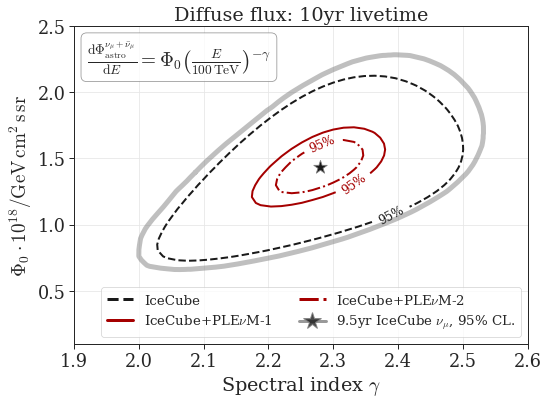

In [31]:
f, ax = plt.subplots(figsize=(8, 6))
## correctly sort extracted contour from joeran's latest diffuse fit
ref_color = "gray"
idx = np.argsort(np.arctan2(joeran[:,1] - np.mean(joeran[:,1]), joeran[:,0] - np.mean(joeran[:,0])))
xx = joeran[:,0][idx]
xx = np.concatenate([[xx[-1]], xx])
yy = joeran[:,1][idx]
yy = np.concatenate([[yy[-1]], yy])
ax.plot(xx, yy, color=ref_color, ls="-", lw=5, alpha=0.5)

# draw contour levels
cvals = [0.05]
lbs = ["95%"]
levels = chi2.isf(cvals, 2)
for ident in idents:
    sc = ax.contour(
        gamma_astro_scaling,
        astro_scaling,
        local_SPL["ts"][ident] - bf_SPL["ts"][ident],
        levels=levels,
        lw=3, **contour_formats[ident]
    )
    fmt = {l: s for l,s in zip(sc.levels, lbs)}
    ax.clabel(sc, levels, fmt=fmt, fontsize=12)
# best fit
ax.scatter(
    bf_SPL["gamma"][ident], bf_SPL["phi_astro"][ident], 
    marker="*", s=200, color="k", edgecolor=ref_color)
lines = [
    matplotlib.lines.Line2D(
        range(1), range(1), 
        color=contour_formats["IceCube"]["colors"][0], 
        ls=contour_formats["IceCube"]["linestyles"],
        lw=3, label="IceCube"),
    matplotlib.lines.Line2D(
        range(1), range(1), 
        color=contour_formats["Plenum-1"]["colors"][0], 
        ls=contour_formats["Plenum-1"]["linestyles"],
        lw=3, label=r"IceCube+PLE$\nu$M-1"),    
    matplotlib.lines.Line2D(
        range(1), range(1), 
        color=contour_formats["Plenum-2"]["colors"][0], 
        ls=contour_formats["Plenum-2"]["linestyles"],
        lw=3, label=r"IceCube+PLE$\nu$M-2"),
    matplotlib.lines.Line2D(
        range(1), range(1), color=ref_color, ls="-", 
        lw=3, markersize=18, alpha=0.8, 
        marker="*", mfc='k', mec=ref_color,
        label=r"9.5yr IceCube $\nu_\mu$, 95% CL."
    )
]
ax.set_ylim(0.1, 2.5)
ax.set_xlim(1.9, 2.6)
ax.legend(handles=lines, loc=4, ncol=2, fontsize="x-small")
ax.set_ylabel(r"$\Phi_0 \cdot 10^{18} / {\rm GeV\, cm^2\, s\, sr}$")
ax.set_xlabel(r"Spectral index $\gamma$")
flux_str = r"$\frac{{\rm d}\Phi_{\rm astro}^{\nu_\mu + \bar{\nu}_\mu}}{{\rm d}E}"
flux_str += r"= \Phi_0 \left( \frac{E}{\rm 100\,TeV} \right)^{-\gamma}$"
ax.text(
    1.92, 2.2, flux_str, fontsize="medium",
    bbox=dict(boxstyle='round', facecolor="w", edgecolor="gray", alpha=0.8)
)
ax.set_title("Diffuse flux: 10yr livetime")
f.tight_layout()
f.savefig(f"../plots/2D_scan_diffuse_spl_comparison.pdf")

### full scan comparison

IceCube
Plenum-1
Plenum-2


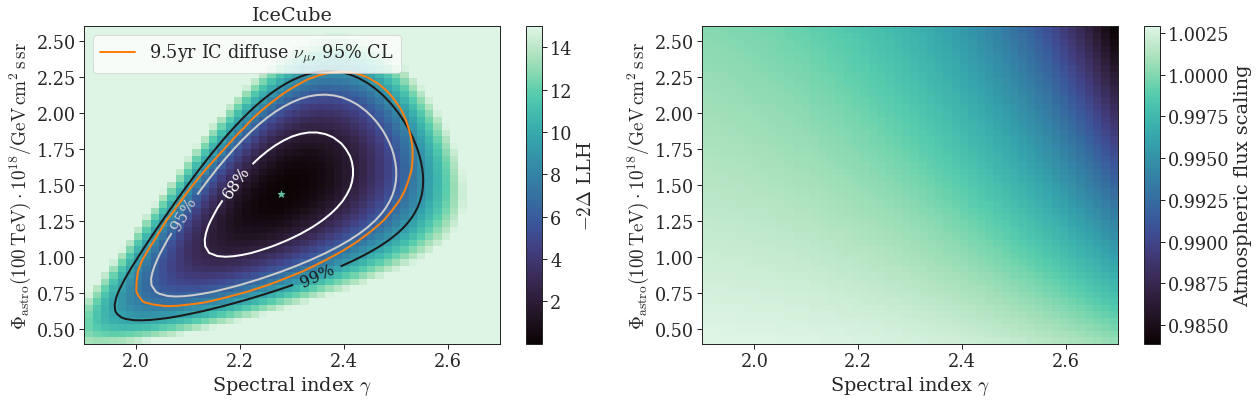

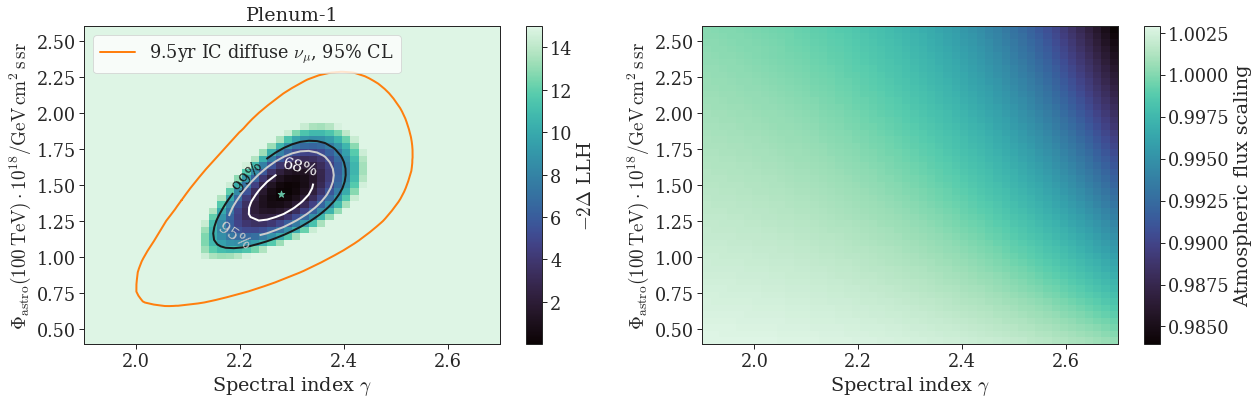

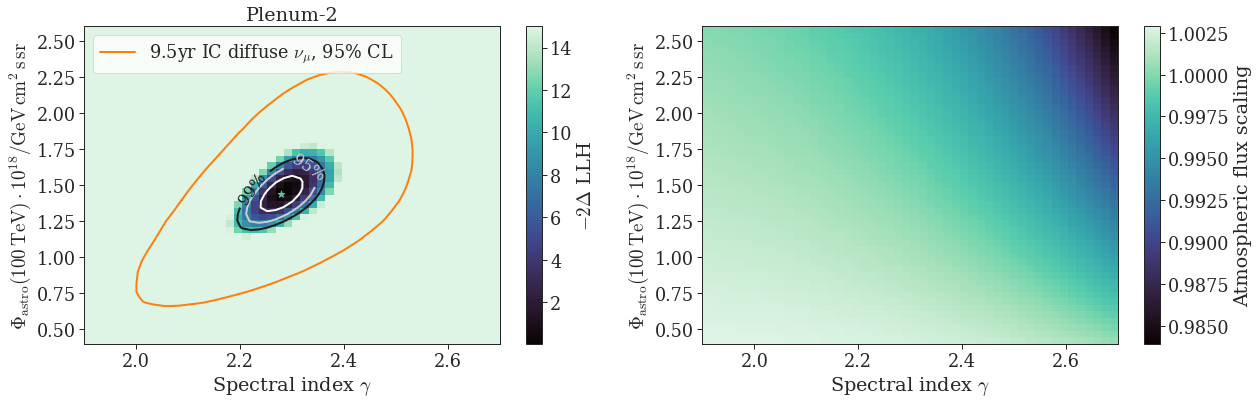

In [32]:
ref_color = "tab:orange"
for ident in idents:
    print(ident)
    ### plotting ###
    f, axes = plt.subplots(ncols=2, figsize=(18,6))
    ax = axes[0]
    # draw llh grid for gamma and astro flux
    im = ax.pcolormesh(
        gamma_astro_scaling,
        astro_scaling,
        local_SPL["ts"][ident] - bf_SPL["ts"][ident],
        vmax=15 # 6 is approx. the 95% quantile of a 2D LLH scan
    )
    cb = plt.colorbar(im, ax=ax)
    # draw contour levels
    cvals = np.array([0.32, 0.05, 0.01])
    levels = chi2.isf(cvals, 2)
    lbs = np.array(["68%", "95%", "99%"])
    sc = ax.contour(
        gamma_astro_scaling,
        astro_scaling,
        local_SPL["ts"][ident] - bf_SPL["ts"][ident],
        levels=levels,
        colors=["w", "0.8", "k"]
    )
    ax.scatter(bf_SPL["gamma"][ident], bf_SPL["phi_astro"][ident], marker="*", s=50)
    fmt = {l: s for l,s in zip(sc.levels, lbs)}
    ax.clabel(sc, levels, fmt=fmt, fontsize=16)
    # correctly sort extracted contour from joeran's latest diffuse fit
    idx = np.argsort(np.arctan2(joeran[:,1] - np.mean(joeran[:,1]), joeran[:,0] - np.mean(joeran[:,0])))
    xx = joeran[:,0][idx]
    xx = np.concatenate([[xx[-1]], xx])
    yy = joeran[:,1][idx]
    yy = np.concatenate([[yy[-1]], yy])
    ax.plot(xx, yy, color=ref_color, label=r"9.5yr IC diffuse $\nu_\mu$, 95% CL")
    ax.legend(loc=2)
    ax.set_ylabel(r"$\Phi_{\rm astro} (100\,{\rm TeV})\cdot 10^{18} / {\rm GeV\, cm^2\, s\, sr}$")
    ax.set_xlabel(r"Spectral index $\gamma$")
    cb.set_label(r"$-2 \Delta$ LLH")
    ax.set_title(ident)


    # in addition, check the nuisance parameter of conventional flux
    ax = axes[1]
    im = ax.pcolormesh(
        gamma_astro_scaling,
        astro_scaling,
        local_SPL["conv"][ident],
    )
    ax.set_ylabel(r"$\Phi_{\rm astro} (100\,{\rm TeV})\cdot 10^{18} / {\rm GeV\, cm^2\, s\, sr}$")
    ax.set_xlabel(r"Spectral index $\gamma$")
    cb = plt.colorbar(im, ax=ax)
    cb.set_label(r"Atmospheric flux scaling")

    f.tight_layout()
    f.savefig(f"../plots/2D_scan_diffuse_spl_{ident}.pdf")

## 1D scan with cutoff

IceCube
starting local fits...
alternative: powerlaw fit (conv, gamma, phi_astro) [0.99828846 2.41854034 1.08941108]
params at min verified with scan: (conv, gamma, phi_astro) 0.9984251868105614 2.14 1.841379310344828
min TS: -1146.4286151608585 verified with scan: -1146.4178136665196
Raw TS vals of powerlaw vs cutoff: -1146.4286151608585 -1148.7294722167612
P-VALUE: 0.12930263418566385 , SIGNIFICANCE: 1.5168576254555715
Plenum-1
starting local fits...
alternative: powerlaw fit (conv, gamma, phi_astro) [0.99830362 2.41449113 1.10020131]
params at min verified with scan: (conv, gamma, phi_astro) 0.998435220423139 2.14 1.841379310344828
min TS: 65.97414338284943 verified with scan: 66.00670069195439
Raw TS vals of powerlaw vs cutoff: 65.97414338284943 57.061764394261445
P-VALUE: 0.0028324403775482794 , SIGNIFICANCE: 2.9853607803057787
Plenum-2
starting local fits...
alternative: powerlaw fit (conv, gamma, phi_astro) [0.99830066 2.41630334 1.09367229]
params at min verified with scan: (co

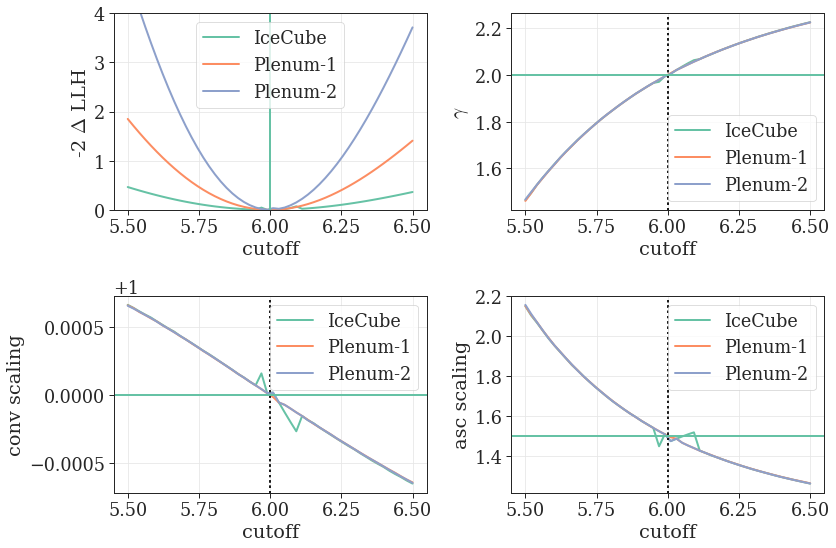

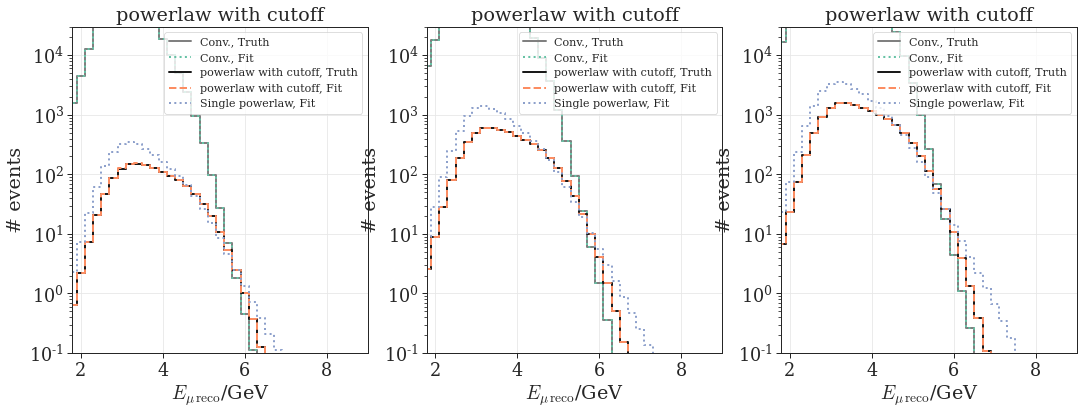

In [33]:
idents = ["IceCube", "Plenum-1", "Plenum-2"]
verbose = False
num = 50
cutoff = np.linspace(5.5, 6.5, num=num)

num1 = 30
gamma_astro_scaling = np.linspace(1.9, 2.7, num=num1+1)
astro_scaling = np.linspace(0.4, 2.6, num=num1)

ts_mins_pl = {}
gamma_mins_pl = {}
phi_astro_mins_pl = {}

f, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
f1, axes1 = plt.subplots(ncols=3, figsize=(18, 6))
for li, ident in enumerate(idents):
    print(ident)
    shape = "powerlaw with cutoff"
    aeff_factor = aeff_eval_e_sd(aeff_2d[ident], sindec_width, ewidth, ra_width) * LIVETIME
    # asimov = expectation of perfect experiment
    k_i = asimov_data(aeff_factor, shape, verbose=verbose)  

    # global min
    out = fmin_l_bfgs_b(
        spectral_ts_func,
        x0=shape_params[shape]["guess"],
        bounds=shape_params[shape]["bounds"],
        approx_grad=True,
        args=(aeff_factor, emids, E_NORM, k_i, shape)
    )
    if out[2]['warnflag'] != 0:
        print("WARNING!!")
    if verbose:
        print("asimov param: ", *shape_params[shape]["baseline"][1:])
        print("guess param: ", *shape_params[shape]["guess"])
        print("bf param:", out[0])
        print("TS:", out[1])
        print("* *"*20)

    local_ts_min = np.zeros(num)
    local_param_min = {
        "gamma": np.zeros(num),
        "conv": np.zeros(num),
        "asc": np.zeros(num)
    }
    for i, cc in enumerate(cutoff):
        # local min with fixed phi_astro
        local_out = fmin_l_bfgs_b(
            local_ts_func,
            x0=shape_params[shape]["guess"][:3],
            bounds=shape_params[shape]["bounds"][:3],
            approx_grad=True,
            args=([cc], (0, 1, 2), (3,), aeff_factor, emids, E_NORM, k_i, shape)
        )
        local_param_min["conv"][i], local_param_min["gamma"][i], local_param_min["asc"][i] = local_out[0]
        local_ts_min[i] = local_out[1]
    
    # best fit powerlaw as null hypothesis     
    out_pl = fmin_l_bfgs_b(
        spectral_ts_func,
        x0=shape_params["powerlaw"]["guess"],
        approx_grad=True,
        args=(aeff_factor, emids, E_NORM, k_i, "powerlaw")
    )
    gamma_mins_pl[ident] = out_pl[0][1]
    phi_astro_mins_pl[ident] = out_pl[0][2]
    ts_mins_pl[ident] = out_pl[1]
    
    ### verify with 2D scan that the result is the correct minimum
    local_ts_min_pl = np.zeros((num1, num1+1))
    local_conv_min_pl = np.zeros((num1, num1+1))
    print("starting local fits...")
    # scan
    for i, asc in enumerate(astro_scaling):
        for j, gas in enumerate(gamma_astro_scaling):
            # local min with fixed phi_astro
            local_out = fmin_l_bfgs_b(
                local_ts_func,
                x0=[1.1],
                approx_grad=True,
                args=([gas, asc], (0, ), (1, 2), aeff_factor, emids, E_NORM, k_i, "powerlaw")
            )
            local_conv_min_pl[i][j], = local_out[0]
            local_ts_min_pl[i][j] = local_out[1]    
    print("alternative: powerlaw fit (conv, gamma, phi_astro)", out_pl[0])
    iag, ias = np.unravel_index(local_ts_min_pl.argmin(), local_ts_min_pl.shape)
    print("params at min verified with scan: (conv, gamma, phi_astro)", 
          local_conv_min_pl.flatten()[local_ts_min_pl.argmin()], gamma_astro_scaling[iag], astro_scaling[ias])
    print("min TS:", out_pl[1], "verified with scan:", np.min(local_ts_min_pl))
    print("Raw TS vals of powerlaw vs cutoff:",out_pl[1], out[1])
    pval = chi2.sf(out_pl[1] - out[1], 1)
    significance = erfinv(1 - pval) * np.sqrt(2)
    print("P-VALUE:", pval, ", SIGNIFICANCE:", significance)

    # plot best-fit event distributions and truth
    
    ax = axes1[li]
    events = [
        np.sum(atmo_background(aeff_factor, spl_vals * shape_params[shape]["baseline"][0]), axis=0),
        np.sum(atmo_background(aeff_factor, spl_vals * out[0][0]), axis=0),
        np.sum(astro_flux(shape, aeff_factor, emids, E_NORM, *shape_params[shape]["baseline"][1:]), axis=0),
        np.sum(astro_flux(shape, aeff_factor, emids, E_NORM, *out[0][1:]), axis=0),
        np.sum(astro_flux("powerlaw", aeff_factor, emids, E_NORM, *out_pl[0][1:]), axis=0)
    ]
    plot_labels = ["Conv., Truth", "Conv., Fit", shape + ", Truth", shape + ", Fit", "Single powerlaw, Fit"]
    ls = ["-", ":", "-", "--", ":"]
    color = ["gray", None, "k", None, None]
    f, ax = plot_spectrum(eri, events, plot_labels, title=shape, f=f, ax=ax, ls=ls, color=color)        
    ax.legend(fontsize="xx-small", loc=1, ncol=2)
    f.tight_layout()

    ## some plots for checking that the scans were ok
    ax = axes[0][0]
    ax.plot(cutoff, local_ts_min- out[1], label=ident)
    ax.set_ylabel(r"-2 $\Delta$ LLH")
    ax.set_xlabel("cutoff")
    ax.legend(loc=0)
    ax.axvline(shape_params[shape]["baseline"][-1], color="k", ls=":")
    ax.axvline(out[0][-1])
    ax.set_ylim(0, 4)
    
    ax = axes[0][1]
    ax.set_ylabel(r"$\gamma$")
    ax.set_xlabel("cutoff")
    ax.plot(cutoff, local_param_min["gamma"], label=ident)
    ax.legend(loc=0)
    ax.axvline(shape_params[shape]["baseline"][-1], color="k", ls=":")
    ax.axhline(shape_params["powerlaw with cutoff"]["baseline"][1])
    
    ax = axes[1][0]
    ax.set_ylabel(r"conv scaling")
    ax.set_xlabel("cutoff")
    ax.plot(cutoff, local_param_min["conv"], label=ident)
    ax.legend(loc=0)
    ax.axvline(shape_params[shape]["baseline"][-1], color="k", ls=":")
    ax.axhline(shape_params["powerlaw with cutoff"]["baseline"][0])
    
    
    ax = axes[1][1]
    ax.set_ylabel(r"asc scaling")
    ax.set_xlabel("cutoff")
    ax.plot(cutoff, local_param_min["asc"], label=ident)
    ax.legend(loc=0)
    ax.axvline(shape_params[shape]["baseline"][-1], color="k", ls=":")
    ax.axhline(shape_params["powerlaw with cutoff"]["baseline"][2])
    axes1[li].legend(fontsize="xx-small", loc=0)
f.tight_layout()

## 2D scans with cutoff

In [34]:
sns.color_palette(many_colors)

[(0.8, 0.8, 0.8),
 (0.4, 0.4, 0.4),
 (0.0, 0.0, 0.0),
 (1.0, 0.7073831810587486, 0.7268393613341471),
 (0.9134588473961229, 0.46107477158812293, 0.49025904200122045),
 (0.713458847396123, 0.261074771588123, 0.29025904200122044),
 (0.5910274350692515, 0.8926168189412514, 0.873160638665853),
 (0.2865411526038771, 0.738925228411877, 0.7097409579987795),
 (0.08654115260387707, 0.5389252284118771, 0.5097409579987795)]

In [35]:
idents = ["IceCube", "Plenum-1", "Plenum-2"]
verbose = False
num = 50
cutoff = np.linspace(4.5, 8.5, num=num)
gamma_astro_scaling = np.linspace(1.0, 2.9, num=num)

In [36]:
bf_PLC = {
    "ts": {},
    "conv": {},
    "gamma": {},
    "phi_astro": {},
    "cutoff": {}
}
local_mins_PLC = {    
    "ts": {},
    "conv": {},
    "phi_astro": {}
}
shape = "powerlaw with cutoff"

for li, ident in enumerate(idents):
    print(ident)
    aeff_factor = aeff_eval_e_sd(aeff_2d[ident], sindec_width, ewidth, ra_width) * LIVETIME
    # asimov = expectation of perfect experiment
    k_i = asimov_data(aeff_factor, shape, verbose=verbose)  

    # global min
    out = fmin_l_bfgs_b(
        spectral_ts_func,
        x0=shape_params[shape]["guess"],
        bounds=shape_params[shape]["bounds"],
        approx_grad=True,
        args=(aeff_factor, emids, E_NORM, k_i, shape)
    )
    bf_PLC["ts"][ident] = out[1]
    bf_PLC["conv"][ident], bf_PLC["gamma"][ident], bf_PLC["phi_astro"][ident], bf_PLC["cutoff"][ident] = out[0]
    if out[2]['warnflag'] != 0:
        print("WARNING!! Something weird happened with the fit")

    local_mins_PLC["ts"][ident] = np.zeros((len(cutoff), len(gamma_astro_scaling)))
    local_mins_PLC["conv"][ident] = np.zeros((len(cutoff), len(gamma_astro_scaling)))
    local_mins_PLC["phi_astro"][ident] = np.zeros((len(cutoff), len(gamma_astro_scaling)))
    print("starting local fits...")
    # scan
    nwarn = 0
    for i, csc in enumerate(cutoff):
        for j, gas in enumerate(gamma_astro_scaling):
            # local min with fixed phi_astro
            local_out = fmin_l_bfgs_b(
                local_ts_func,
                x0=shape_params[shape]["baseline"][[0, 2]],
                bounds=shape_params[shape]["bounds"][[0, 2]]*((1, 1), (0.3, 3)), # losen up bounds a bit here for astro
                approx_grad=True,
                args=([gas, csc], (0, 2), (1, 3), aeff_factor, emids, E_NORM, k_i, shape),
                maxls=35
            )
            if local_out[2]['warnflag'] == 0:
                local_mins_PLC["conv"][ident][i][j], local_mins_PLC["phi_astro"][ident][i][j] = local_out[0]
                local_mins_PLC["ts"][ident][i][j] = local_out[1]
            else:
                strng = "WARNING!! Something weird happened with the fit"
                strng += "\nParameters: cutoff={}, gamma={}".format(csc, gas)
                strng += "\n Fit Output:" + str(local_out)
                #print(strng)
                local_mins_PLC["conv"][ident][i][j] = np.nan
                local_mins_PLC["phi_astro"][ident][i][j] = np.nan
                local_mins_PLC["ts"][ident][i][j] = np.nan
                nwarn += 1
    print("Number of warnings:", nwarn)
    print("Done")

IceCube
starting local fits...
Number of warnings: 7
Done
Plenum-1
starting local fits...
Number of warnings: 6
Done
Plenum-2
starting local fits...
Number of warnings: 3
Done


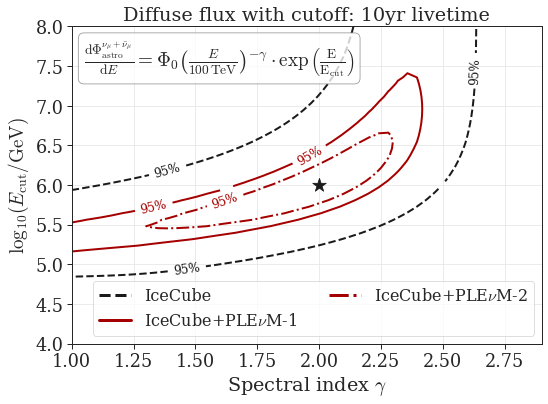

In [37]:
f, ax = plt.subplots(figsize=(8, 6))
cvals = [0.05]
lbs = ["95%"]
levels = chi2.isf(cvals, 2)
for ident in idents:
    # draw contour levels
    sc = ax.contour(
        gamma_astro_scaling,
        cutoff,
        local_mins_PLC["ts"][ident] - bf_PLC["ts"][ident],
        levels=levels,
        lw=3, **contour_formats[ident]
    )
    fmt = {l: s for l,s in zip(sc.levels, lbs)}
    ax.clabel(sc, levels, fmt=fmt, fontsize=12)
    
ax.scatter(bf_PLC["gamma"][ident], bf_PLC["cutoff"][ident], marker="*", s=200, color="k")
handles, _ = ax.get_legend_handles_labels()
handles.extend([
    matplotlib.lines.Line2D(
        range(1), range(1), 
        color=contour_formats["IceCube"]["colors"][0], ls=contour_formats["IceCube"]["linestyles"], lw=3, label="IceCube"),
    matplotlib.lines.Line2D(
        range(1), range(1), 
        color=contour_formats["Plenum-1"]["colors"][0], ls=contour_formats["Plenum-1"]["linestyles"], lw=3, label=r"IceCube+PLE$\nu$M-1"),    
    matplotlib.lines.Line2D(
        range(1), range(1), 
        color=contour_formats["Plenum-2"]["colors"][0], ls=contour_formats["Plenum-2"]["linestyles"], lw=3, label=r"IceCube+PLE$\nu$M-2")
])
ax.legend(handles=handles, loc=4, ncol=2, fontsize="small")
ax.set_ylim(4.0, 8)
flux_str = r"$\frac{{\rm d}\Phi_{\rm astro}^{\nu_\mu + \bar{\nu}_\mu}}{{\rm d}E}"
flux_str += r"= \Phi_0 \left( \frac{E}{\rm 100\,TeV} \right)^{-\gamma}"
flux_str += r" \cdot \exp \left( \frac{E}{E_{\rm cut}}\right)$"
ax.text(
    1.05, 7.5, flux_str, fontsize="medium",
    bbox=dict(boxstyle='round', facecolor="w", edgecolor="gray", alpha=0.8)
)
ax.set_ylabel(r"$\log_{10}(E_{\rm cut} / {\rm GeV})$")
ax.set_xlabel(r"Spectral index $\gamma$")
ax.set_title("Diffuse flux with cutoff: 10yr livetime")
f.tight_layout()
f.savefig(f"../plots/2D_scan_diffuse_pl-cut_comparison_gamma-cut.pdf")

IceCube
Plenum-1
Plenum-2


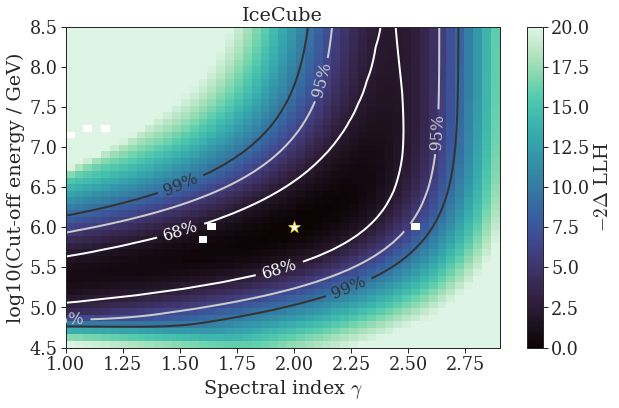

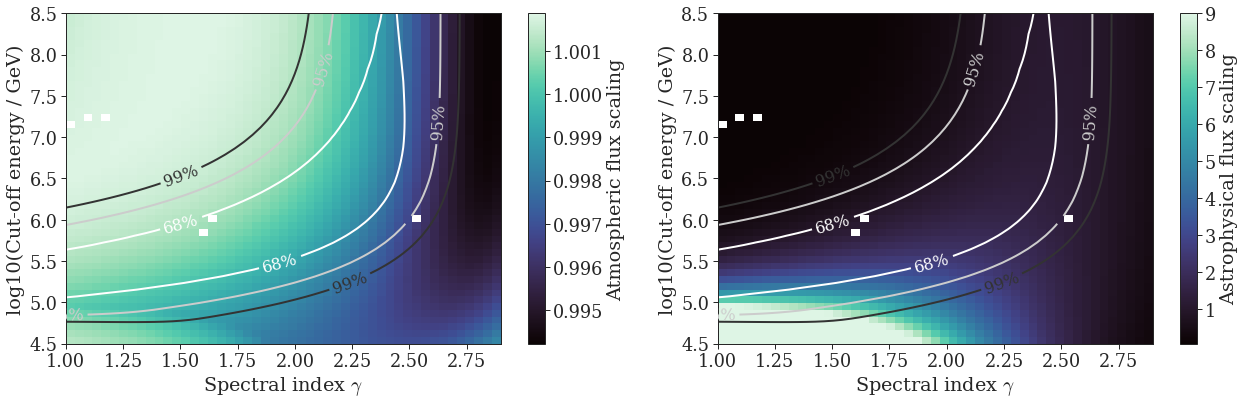

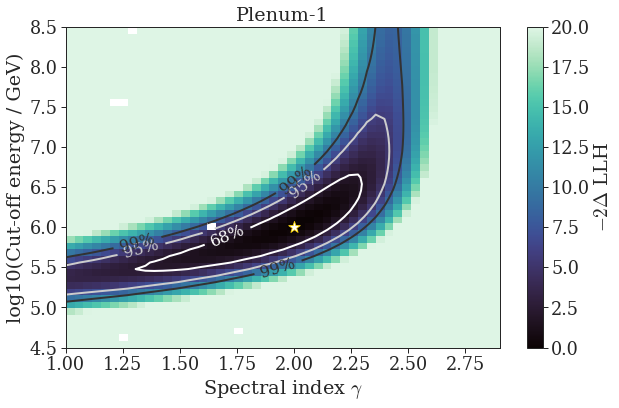

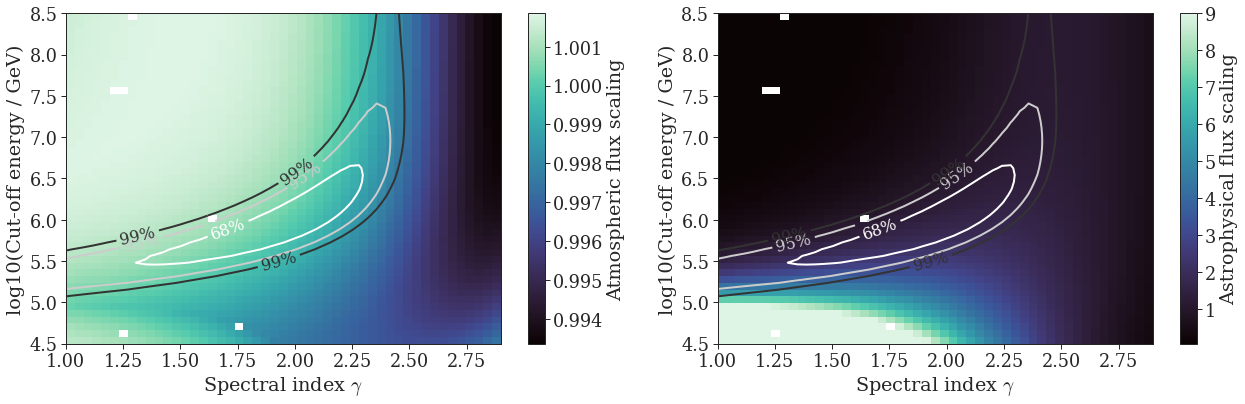

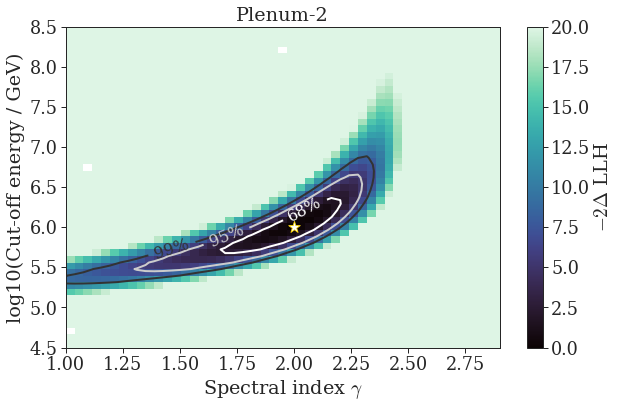

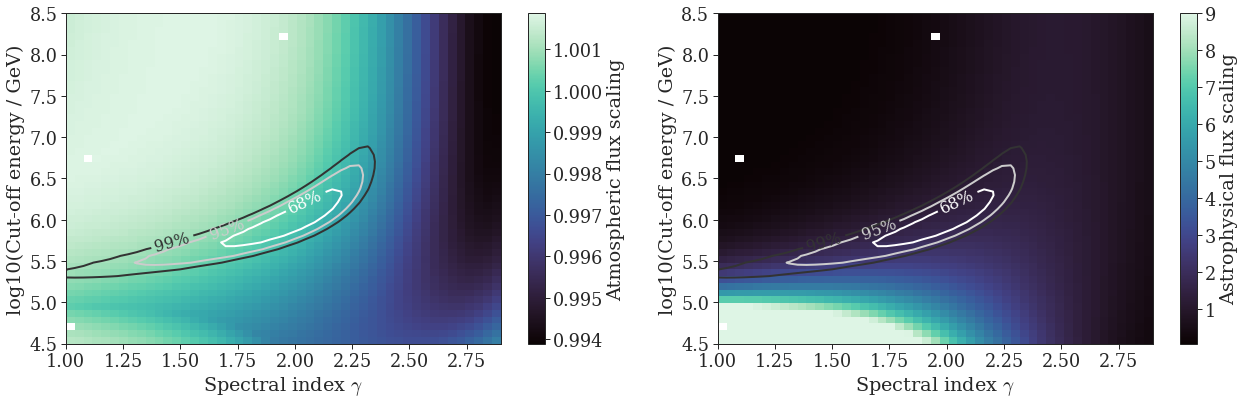

In [38]:
for ident in idents:
    print(ident)
    ### plotting ###
    f, ax = plt.subplots(figsize=(9,6))
    # draw llh grid for gamma and astro flux
    im = ax.pcolormesh(
        gamma_astro_scaling,
        cutoff,
        local_mins_PLC["ts"][ident] - bf_PLC["ts"][ident],
        vmin=0,
        vmax=20
    )
    cb = plt.colorbar(im, ax=ax)
    
    # draw contour levels
    cvals = np.array([0.32, 0.05, 0.01])
    levels = chi2.isf(cvals, 2)
    lbs = np.array(["68%", "95%", "99%"])
    sc = ax.contour(
        gamma_astro_scaling,
        cutoff,
        local_mins_PLC["ts"][ident] - bf_PLC["ts"][ident],
        levels=levels,
        colors=["w", "0.8", "0.2"]
    )
    ax.scatter(bf_PLC["gamma"][ident], bf_PLC["cutoff"][ident], marker="*", s=150, color="white", edgecolor="gold")
    fmt = {l: s for l,s in zip(sc.levels, lbs)}
    ax.clabel(sc, levels, fmt=fmt, fontsize=16)
    
    ax.set_ylabel(r"log10(Cut-off energy / GeV)")
    ax.set_xlabel(r"Spectral index $\gamma$")
    cb.set_label(r"$-2 \Delta$ LLH")
    ax.set_title(ident)
    f.tight_layout()
    f.savefig(f"../plots/2D_scan_diffuse_pl-cut_{ident}.pdf")

    f2, ax2 = plt.subplots(ncols=2, figsize=(18,6))
    ## in addition, check the nuisance parameter of conventional flux
    ax = ax2[0]
    im = ax.pcolormesh(
        gamma_astro_scaling,
        cutoff,
        local_mins_PLC["conv"][ident],
        #vmin=0.99,
    )
    
    ## add contours as reference
    sc = ax.contour(
        gamma_astro_scaling,
        cutoff,
        local_mins_PLC["ts"][ident] - bf_PLC["ts"][ident],
        levels=levels,
        colors=["w", "0.8", "0.2"]
    )
    fmt = {l: s for l,s in zip(sc.levels, lbs)}
    ax.clabel(sc, levels, fmt=fmt, fontsize=16)
    ax.set_ylabel(r"log10(Cut-off energy / GeV)")
    ax.set_xlabel(r"Spectral index $\gamma$")
    cb = plt.colorbar(im, ax=ax)
    cb.set_label(r"Atmospheric flux scaling")
    f.tight_layout()
    
    ax = ax2[1]
    im2 = ax.pcolormesh(
        gamma_astro_scaling,
        cutoff,
        local_mins_PLC["phi_astro"][ident],
        #vmin=0.99,
    )
    ## add contours as reference
    sc = ax.contour(
        gamma_astro_scaling,
        cutoff,
        local_mins_PLC["ts"][ident] - bf_PLC["ts"][ident],
        levels=levels,
        colors=["w", "0.8", "0.2"]
    )
    fmt = {l: s for l,s in zip(sc.levels, lbs)}
    ax.clabel(sc, levels, fmt=fmt, fontsize=16)
    ax.set_ylabel(r"log10(Cut-off energy / GeV)")
    ax.set_xlabel(r"Spectral index $\gamma$")
    cb = plt.colorbar(im2, ax=ax)
    cb.set_label(r"Astrophysical flux scaling")
    f2.tight_layout()
    

# Cutoff significance versus time/detectors

Some options:
* 10yr IceCube
* 20yr IceCube
* 40yr IceCube
* 10yr IceCube + K3N
* 10yr IceCube + K3N + GVD
* 10yr IceCube + K3N + GVD + PONE
* 10yr IceCube +  2yr baseline Plenum (= IC + PONE + GVD + K3N)
* 10yr IceCube +  5yr baseline Plenum (= IC + PONE + GVD + K3N)
* 10yr IceCube + 10yr baseline Plenum (= IC + PONE + GVD + K3N)
* 10yr IceCube +  2yr Plenum-2 (= GEN2 + PONE + GVD + K3N)
* 10yr IceCube +  5yr Plenum-2 (= GEN2 + PONE + GVD + K3N)
* 10yr IceCube + 10yr Plenum-2 (= GEN2 + PONE + GVD + K3N)

In [39]:
# livetime relative to 10yrs
detector_configurations = [
    {"IceCube": 1.0, "Gen-2": 0, "Plenum-1": 0, "KM3NeT":  0, "P-ONE": 0, "Baikal-GVD": 0, "identifier": "10y IC"},
    {"IceCube": 2.0, "Gen-2": 0, "Plenum-1": 0, "KM3NeT":  0, "P-ONE": 0, "Baikal-GVD": 0, "identifier": "20y IC"},
    {"IceCube": 4.0, "Gen-2": 0, "Plenum-1": 0, "KM3NeT":  0, "P-ONE": 0, "Baikal-GVD": 0, "identifier": "40y IC"},
    #{"IceCube": 1.0, "Gen-2": 0, "Plenum-1": 0, "KM3NeT":  1, "P-ONE": 0, "Baikal-GVD": 0, "identifier": "10y IC + 10y K3"},
    #{"IceCube": 1.0, "Gen-2": 0, "Plenum-1": 0, "KM3NeT":  1, "P-ONE": 0, "Baikal-GVD": 1, "identifier": "10y IC + 10y K3 + 10y BG"},
    #{"IceCube": 1.0, "Gen-2": 0, "Plenum-1": 0, "KM3NeT":  1, "P-ONE": 1, "Baikal-GVD": 1, "identifier": "10y IC + 10y K3 + 10y BG + 10y PO"},
    {"IceCube": 1.0, "Gen-2": 0, "Plenum-1": 0.2, "KM3NeT":  0, "P-ONE": 0, "Baikal-GVD": 0, "identifier": "10y IC + 2y PL-1"},
    {"IceCube": 1.0, "Gen-2": 0, "Plenum-1": 0.5, "KM3NeT":  0, "P-ONE": 0, "Baikal-GVD": 0, "identifier": "10y IC + 5y PL-1"},
    {"IceCube": 1.0, "Gen-2": 0, "Plenum-1": 1, "KM3NeT":  0, "P-ONE": 0, "Baikal-GVD": 0, "identifier": "10y IC + 10y PL-1"},
    {"IceCube": 1.0, "Gen-2": 0.2, "Plenum-1": 0, "KM3NeT": 0.2, "P-ONE": 0.2, "Baikal-GVD": 0.2, "identifier": "10y IC + 2y PL-2"},
    {"IceCube": 1.0, "Gen-2": 0.5, "Plenum-1": 0, "KM3NeT": 0.5, "P-ONE": 0.5, "Baikal-GVD": 0.5, "identifier": "10y IC + 5y PL-2"},
    {"IceCube": 1.0, "Gen-2": 1, "Plenum-1": 0, "KM3NeT": 1, "P-ONE": 1, "Baikal-GVD": 1, "identifier": "10y IC + 10y PL-2"},
]
detector_configurations = pd.DataFrame(detector_configurations)

In [40]:
pvals = []
shape = "powerlaw with cutoff"

for idx, series in detector_configurations.iterrows():
    print(idx)
    aeff_factor = np.zeros_like(aeff_2d["IceCube"].T)
    naming = ""
    for ident, lt_factor in series.items():
        if ident=="identifier": continue
        if lt_factor==0 : continue
        print(ident)
        aeff_factor += aeff_eval_e_sd(aeff_2d[ident], sindec_width, ewidth, ra_width) * LIVETIME * lt_factor
    # asimov = expectation of perfect experiment
    k_i = asimov_data(aeff_factor, shape, verbose=verbose)  

    # global min
    out = fmin_l_bfgs_b(
        spectral_ts_func,
        x0=shape_params[shape]["guess"],
        bounds=shape_params[shape]["bounds"],
        approx_grad=True,
        args=(aeff_factor, emids, E_NORM, k_i, shape)
    )
    # check that the TS at the fit minimum is close to the TS of the baseline params
    baseline_ts_check = np.isclose(
        out[1], spectral_ts_func(
            shape_params[shape]["baseline"],
            aeff_factor, emids, E_NORM, k_i, shape
        ), rtol=1E-2
    )
    print("TS asimov check:", "OK" if baseline_ts_check else "not OK :(")
    # best fit powerlaw as null hypothesis     
    out_pl = fmin_l_bfgs_b(
        spectral_ts_func,
        x0=shape_params["powerlaw"]["guess"],
        bounds=shape_params["powerlaw"]["bounds"],
        approx_grad=True,
        args=(aeff_factor, emids, E_NORM, k_i, "powerlaw")
    )
    pval = chi2.sf(out_pl[1] - out[1], 1)
    sigma = erfinv(1 - pval) * np.sqrt(2)
    print("P-VALUE:", pval, ", SIGNIFICANCE:", sigma)
    pvals.append({"identifier": series.identifier, #str(idx) + ", " + 
                  "idx": idx, "pval": pval, r"Significance in $\sigma$": sigma})

pval_df = pd.DataFrame(pvals)
pval_df[r"$-\log_{10}$(p-value)"] = -np.log10(pval_df.pval)

0
IceCube
TS asimov check: OK
P-VALUE: 0.12930263075144388 , SIGNIFICANCE: 1.5168576390547535
1
IceCube
TS asimov check: OK
P-VALUE: 0.031939535325270586 , SIGNIFICANCE: 2.1451665212805113
2
IceCube
TS asimov check: OK
P-VALUE: 0.002415548877098604 , SIGNIFICANCE: 3.0337245276675966
3
IceCube
Plenum-1
TS asimov check: OK
P-VALUE: 0.04463910338182665 , SIGNIFICANCE: 2.008039415333037
4
IceCube
Plenum-1
TS asimov check: OK
P-VALUE: 0.00976068058016739 , SIGNIFICANCE: 2.5841942430479623
5
IceCube
Plenum-1
TS asimov check: OK
P-VALUE: 0.0008560794331771652 , SIGNIFICANCE: 3.3339958230732454
6
IceCube
Gen-2
KM3NeT
P-ONE
Baikal-GVD
TS asimov check: OK
P-VALUE: 0.008170425576068391 , SIGNIFICANCE: 2.6449447528284855
7
IceCube
Gen-2
KM3NeT
P-ONE
Baikal-GVD
TS asimov check: OK
P-VALUE: 0.00017777111499835005 , SIGNIFICANCE: 3.748675224188818
8
IceCube
Gen-2
KM3NeT
P-ONE
Baikal-GVD
TS asimov check: OK
P-VALUE: 3.753689560053482e-07 , SIGNIFICANCE: 5.0810425815864635


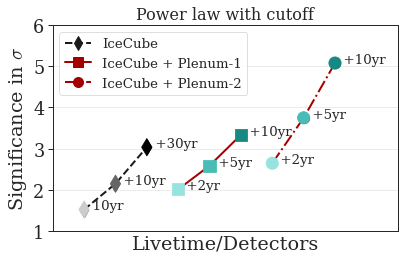

In [41]:
f, ax = plt.subplots()
label_size = "x-small"
# ICECUBE
ax.plot(
    pval_df.loc[[0, 1, 2]]["identifier"], 
    pval_df.loc[[0, 1, 2]][r"Significance in $\sigma$"],
    ls=contour_formats["IceCube"]["linestyles"], color=poles["IceCube"]["color"],
    marker="d", label="IceCube", ms=10
)
ax.scatter(
    x=pval_df.loc[[0, 1, 2]]["identifier"], 
    y=pval_df.loc[[0, 1, 2]][r"Significance in $\sigma$"], 
    c=many_colors[:3], s=150, zorder=10, marker="d"
)
ax.text(
    x=pval_df.loc[0]["identifier"], 
    y=pval_df.loc[0][r"Significance in $\sigma$"],
    s="  10yr", fontsize=label_size
)
ax.text(
    x=pval_df.loc[1]["identifier"], 
    y=pval_df.loc[1][r"Significance in $\sigma$"],
    s="  +10yr", fontsize=label_size
)
ax.text(
    x=pval_df.loc[2]["identifier"], 
    y=pval_df.loc[2][r"Significance in $\sigma$"],
    s="  +30yr", fontsize=label_size
)

## PLENUM-1
ax.plot(
    pval_df.loc[[3, 4, 5]]["identifier"], 
    pval_df.loc[[3, 4, 5]][r"Significance in $\sigma$"],
    ls=poles["Plenum-1"]["ls"], color=poles["Plenum-1"]["color"],
    marker="s", label="IceCube + Plenum-1", ms=10
)
ax.scatter(
    x=pval_df.loc[[3, 4, 5]]["identifier"], 
    y=pval_df.loc[[3, 4, 5]][r"Significance in $\sigma$"], 
    c=many_colors[6:], s=150, zorder=10, marker="s"
)
ax.text(
    x=pval_df.loc[3]["identifier"], 
    y=pval_df.loc[3][r"Significance in $\sigma$"],
    s="  +2yr", fontsize=label_size
)
ax.text(
    x=pval_df.loc[4]["identifier"], 
    y=pval_df.loc[4][r"Significance in $\sigma$"],
    s="  +5yr", fontsize=label_size
)
ax.text(
    x=pval_df.loc[5]["identifier"], 
    y=pval_df.loc[5][r"Significance in $\sigma$"],
    s="  +10yr", fontsize=label_size
)


## PLENUM-2
ax.plot(
    pval_df.loc[[6, 7, 8]]["identifier"], 
    pval_df.loc[[6, 7, 8]][r"Significance in $\sigma$"],
    ls=poles["Plenum-2"]["ls"], color=poles["Plenum-2"]["color"],
    marker="o", label="IceCube + Plenum-2", ms=10
)
ax.scatter(
    x=pval_df.loc[[6, 7, 8]]["identifier"], 
    y=pval_df.loc[[6, 7, 8]][r"Significance in $\sigma$"], 
    c=many_colors[6:], s=150, zorder=10, marker="o"
)
ax.text(
    x=pval_df.loc[6]["identifier"], 
    y=pval_df.loc[6][r"Significance in $\sigma$"],
    s="  +2yr", fontsize=label_size
)
ax.text(
    x=pval_df.loc[7]["identifier"], 
    y=pval_df.loc[7][r"Significance in $\sigma$"],
    s="  +5yr", fontsize=label_size
)
ax.text(
    x=pval_df.loc[8]["identifier"], 
    y=pval_df.loc[8][r"Significance in $\sigma$"],
    s="  +10yr", fontsize=label_size
)

ax.set_xlim(-1, 10)
ax.set_ylim(1, 6)
ax.set_xticks([])
ax.legend(fontsize="x-small")
ax.set_title("Power law with cutoff", fontsize="small")
ax.set_xlabel("Livetime/Detectors")
ax.set_ylabel(r"Significance in $\sigma$")
plt.tight_layout()
plt.savefig("../plots/cutoff_sigma_vs_det_talk.pdf")

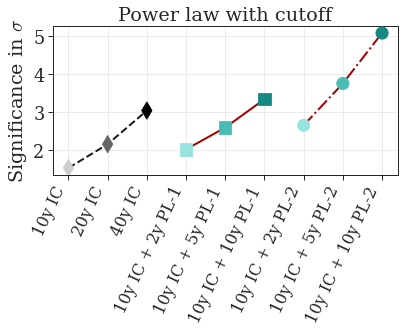

In [42]:
f, ax = plt.subplots(figsize=(6, 5))

ax.plot(
    pval_df.loc[[0, 1, 2]]["identifier"], 
    pval_df.loc[[0, 1, 2]][r"Significance in $\sigma$"],
    ls=contour_formats["IceCube"]["linestyles"], color=poles["IceCube"]["color"]
)
ax.scatter(
    x=pval_df.loc[[0, 1, 2]]["identifier"], 
    y=pval_df.loc[[0, 1, 2]][r"Significance in $\sigma$"], 
    c=many_colors[:3], s=150, zorder=10, marker="d"
)

ax.plot(
    pval_df.loc[[3, 4, 5]]["identifier"], 
    pval_df.loc[[3, 4, 5]][r"Significance in $\sigma$"],
    ls=poles["Plenum-1"]["ls"], color=poles["Plenum-1"]["color"]
)
ax.scatter(
    x=pval_df.loc[[3, 4, 5]]["identifier"], 
    y=pval_df.loc[[3, 4, 5]][r"Significance in $\sigma$"], 
    c=many_colors[6:], s=150, zorder=10, marker="s"
)

ax.plot(
    pval_df.loc[[6, 7, 8]]["identifier"], 
    pval_df.loc[[6, 7, 8]][r"Significance in $\sigma$"],
    ls=poles["Plenum-2"]["ls"], color=poles["Plenum-2"]["color"]
)
ax.scatter(
    x=pval_df.loc[[6, 7, 8]]["identifier"], 
    y=pval_df.loc[[6, 7, 8]][r"Significance in $\sigma$"], 
    c=many_colors[6:], s=150, zorder=10, marker="o"
)


#ax.set_ylim(0, 5.5)
ax.set_title("Power law with cutoff")
ax.set_xlabel("")
ax.set_ylabel(r"Significance in $\sigma$")
plt.xticks(rotation=65, fontsize="small", ha="right")
plt.tight_layout()
plt.savefig("../plots/cutoff_sigma_vs_det.pdf")

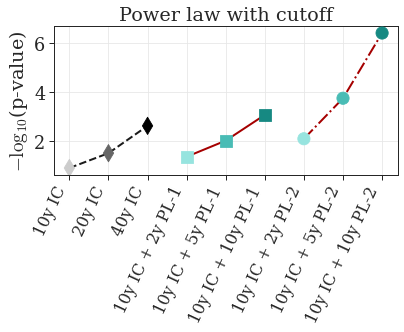

In [43]:
f, ax = plt.subplots(figsize=(6, 5))
ax.plot(
    pval_df.loc[[0, 1, 2]]["identifier"], 
    pval_df.loc[[0, 1, 2]][r"$-\log_{10}$(p-value)"],
    ls=contour_formats["IceCube"]["linestyles"], color=poles["IceCube"]["color"]
)
ax.scatter(
    x=pval_df.loc[[0, 1, 2]]["identifier"], 
    y=pval_df.loc[[0, 1, 2]][r"$-\log_{10}$(p-value)"], 
    c=many_colors[:3], s=150, zorder=10, marker="d"
)

ax.plot(
    pval_df.loc[[3, 4, 5]]["identifier"], 
    pval_df.loc[[3, 4, 5]][r"$-\log_{10}$(p-value)"],
    ls=poles["Plenum-1"]["ls"], color=poles["Plenum-1"]["color"]
)
ax.scatter(
    x=pval_df.loc[[3, 4, 5]]["identifier"], 
    y=pval_df.loc[[3, 4, 5]][r"$-\log_{10}$(p-value)"], 
    c=many_colors[6:], s=150, zorder=10, marker="s"
)

ax.plot(
    pval_df.loc[[6, 7, 8]]["identifier"], 
    pval_df.loc[[6, 7, 8]][r"$-\log_{10}$(p-value)"],
    ls=poles["Plenum-2"]["ls"], color=poles["Plenum-2"]["color"]
)
ax.scatter(
    x=pval_df.loc[[6, 7, 8]]["identifier"], 
    y=pval_df.loc[[6, 7, 8]][r"$-\log_{10}$(p-value)"], 
    c=many_colors[6:], s=150, zorder=10, marker="o"
)

ax.set_title("Power law with cutoff")
ax.set_xlabel("")
ax.set_ylabel(r"$-\log_{10}$(p-value)")
plt.xticks(rotation=65, fontsize="small", ha="right")
plt.tight_layout()
plt.savefig("../plots/cutoff_pval_vs_det.pdf")

## Significance vs cutoff value

In [44]:
print_names = {
    "IceCube": "IceCube",
    "Plenum-1": r"IceCube + PLE$\nu$M-1",
    "Plenum-2": r"IceCube + PLE$\nu$M-2"
}

In [45]:
pvals = []
cutoff_vals = np.round(np.arange(5.0, 8.1, step=0.2), 1)
for e_cut in cutoff_vals:
    for li, ident in enumerate(idents):
        shape = "powerlaw with cutoff"
        aeff_factor = aeff_eval_e_sd(aeff_2d[ident], sindec_width, ewidth, ra_width) * LIVETIME
        if "Plenum" in ident:
            aeff_factor += aeff_eval_e_sd(aeff_2d["IceCube"], sindec_width, ewidth, ra_width) * LIVETIME
        # asimov = expectation of perfect experiment
        shp_params = np.copy(shape_params[shape]["baseline"])
        shp_params[-1] = e_cut
        k_i = asimov_data(
            aeff_factor, shape, verbose=False, shp_params=shp_params)

        # global min
        out = fmin_l_bfgs_b(
            spectral_ts_func,
            x0=shape_params[shape]["guess"],
            bounds=shape_params[shape]["bounds"],
            approx_grad=True,
            args=(aeff_factor, emids, E_NORM, k_i, shape)
        )
        # check that the TS at the fit minimum is close to the TS of the baseline params
        reference = spectral_ts_func(
            shp_params,
            aeff_factor, emids, E_NORM, k_i, shape
        )
        baseline_ts_check = np.isclose(out[1], reference, rtol=1E-2)
        print("TS asimov check:", "OK" if baseline_ts_check else "not OK :(")
        if not baseline_ts_check:
            print("e_cut:", shp_params[-1])
            print("fit: ", out[1], ", reference:", reference)
        # best fit powerlaw as null hypothesis     
        out_pl = fmin_l_bfgs_b(
            spectral_ts_func,
            x0=shape_params["powerlaw"]["guess"],
            bounds=shape_params["powerlaw"]["bounds"],
            approx_grad=True,
            args=(aeff_factor, emids, E_NORM, k_i, "powerlaw")
        )
        pval = chi2.sf(out_pl[1] - out[1], 1)
        significance = erfinv(1 - pval) * np.sqrt(2)
        # print("P-VALUE:", pval, ", SIGNIFICANCE:", significance)
        pvals.append({"ident": print_names[ident], "pval": pval, 
                      r"Significance in $\sigma$": significance, 
                      r"$\log_{10}(E_{\rm cut}/{\rm GeV})$": e_cut,
                      r"Conv_PL": out_pl[0][0],
                      r"$\gamma_{PL}$": out_pl[0][1],
                      r"$\Phi_{0,PL}$": out_pl[0][2],
                      r"Conv": out[0][0],
                      r"$\gamma$": out[0][1],
                      r"$\Phi_{0}$": out[0][2],
                      r"$E_{\rm cut}$": out[0][3]
                     })

pval_df = pd.DataFrame(pvals)
pval_df[r"$-\log_{10}$(p-value)"] = -np.log10(pval_df.pval)

TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK


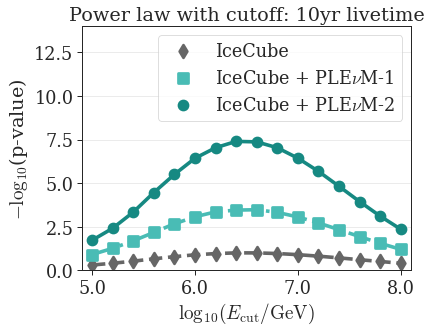

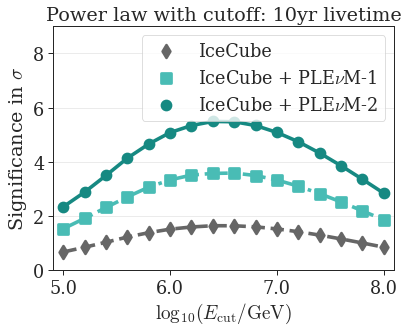

In [46]:
f, ax = plt.subplots(figsize=(6, 5))
ax = sns.pointplot(
    data=pval_df, hue="ident", ax=ax,
    y=r"$-\log_{10}$(p-value)", x=r"$\log_{10}(E_{\rm cut}/{\rm GeV})$", 
    palette=many_colors[[1, 7, 8]], linestyles=["--", "-.", "-"], markers=["d", "s", "o"]
)
ax.set_title("Power law with cutoff: 10yr livetime") #, fontsize="small")
ax.set_xticks(np.arange(0, len(cutoff_vals), step=5))
ax.legend(loc=1) #, fontsize="x-small")
ax.set_ylim(0, 14)
plt.tight_layout()
plt.savefig("../plots/cutoff_pval_vs_cutoff.pdf")

f, ax = plt.subplots(figsize=(6, 5))
ax = sns.pointplot(
    data=pval_df, hue="ident", ax=ax,
    y=r"Significance in $\sigma$", x=r"$\log_{10}(E_{\rm cut}/{\rm GeV})$", 
    palette=many_colors[[1, 7, 8]], linestyles=["--", "-.", "-"], markers=["d", "s", "o"]
)
ax.set_title("Power law with cutoff: 10yr livetime") #, fontsize="small")
ax.set_xticks(np.arange(0, len(cutoff_vals), step=5))
ax.legend(loc=1) #, fontsize="x-small")
ax.set_ylim(0, 9)
f.tight_layout()
plt.savefig("../plots/cutoff_sigma_vs_cutoff.pdf")

## check that parameter fits are ok

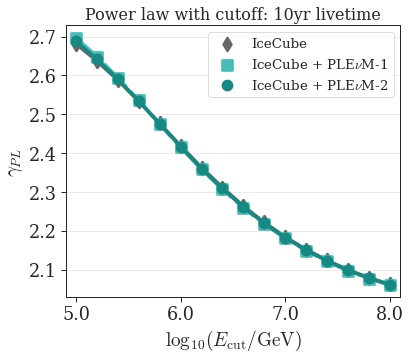

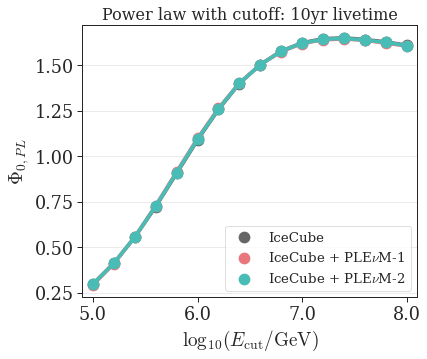

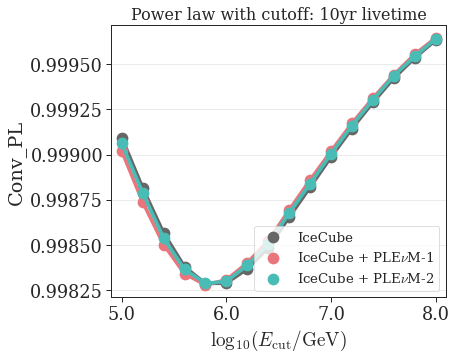

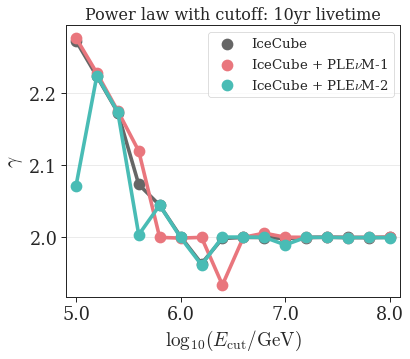

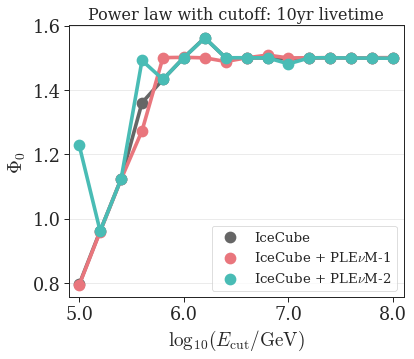

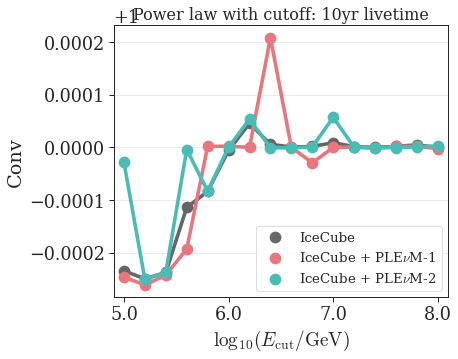

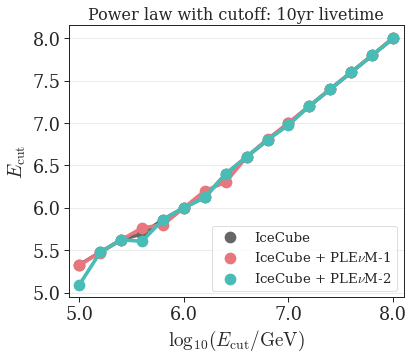

In [47]:
f, ax = plt.subplots(figsize=(6, 5))
ax = sns.pointplot(
    data=pval_df, hue="ident", ax=ax,
    y=r"$\gamma_{PL}$", x=r"$\log_{10}(E_{\rm cut}/{\rm GeV})$", 
    palette=many_colors[[1, 7, 8]], linestyles=["-", "-.", "-"], markers=["d", "s", "o"]
)
ax.set_title("Power law with cutoff: 10yr livetime", fontsize="small")
ax.set_xticks(np.arange(0, len(cutoff_vals), step=5))
ax.legend(loc=1, fontsize="x-small")

f, ax = plt.subplots(figsize=(6, 5))
ax = sns.pointplot(
    data=pval_df, hue="ident", ax=ax,
    y=r"$\Phi_{0,PL}$", x=r"$\log_{10}(E_{\rm cut}/{\rm GeV})$",
    palette=many_colors[[1, 4, 7]]
)
ax.set_title("Power law with cutoff: 10yr livetime", fontsize="small")
ax.set_xticks(np.arange(0, len(cutoff_vals), step=5))
ax.legend(loc=4, fontsize="x-small")

f, ax = plt.subplots(figsize=(6, 5))
ax = sns.pointplot(
    data=pval_df, hue="ident", ax=ax,
    y=r"Conv_PL", x=r"$\log_{10}(E_{\rm cut}/{\rm GeV})$",
    palette=many_colors[[1, 4, 7]]
)
ax.set_title("Power law with cutoff: 10yr livetime", fontsize="small")
ax.set_xticks(np.arange(0, len(cutoff_vals), step=5))
ax.legend(loc=4, fontsize="x-small")

f, ax = plt.subplots(figsize=(6, 5))
ax = sns.pointplot(
    data=pval_df, hue="ident", ax=ax,
    y=r"$\gamma$", x=r"$\log_{10}(E_{\rm cut}/{\rm GeV})$",
    palette=many_colors[[1, 4, 7]]
)
ax.set_title("Power law with cutoff: 10yr livetime", fontsize="small")
ax.set_xticks(np.arange(0, len(cutoff_vals), step=5))
ax.legend(loc=1, fontsize="x-small")

f, ax = plt.subplots(figsize=(6, 5))
ax = sns.pointplot(
    data=pval_df, hue="ident", ax=ax,
    y=r"$\Phi_{0}$", x=r"$\log_{10}(E_{\rm cut}/{\rm GeV})$",
    palette=many_colors[[1, 4, 7]]
)
ax.set_title("Power law with cutoff: 10yr livetime", fontsize="small")
ax.set_xticks(np.arange(0, len(cutoff_vals), step=5))
ax.legend(loc=4, fontsize="x-small")

f, ax = plt.subplots(figsize=(6, 5))
ax = sns.pointplot(
    data=pval_df, hue="ident", ax=ax,
    y=r"Conv", x=r"$\log_{10}(E_{\rm cut}/{\rm GeV})$",
    palette=many_colors[[1, 4, 7]]
)
ax.set_title("Power law with cutoff: 10yr livetime", fontsize="small")
ax.set_xticks(np.arange(0, len(cutoff_vals), step=5))
ax.legend(loc=4, fontsize="x-small")

f, ax = plt.subplots(figsize=(6, 5))
ax = sns.pointplot(
    data=pval_df, hue="ident", ax=ax,
    y=r"$E_{\rm cut}$", x=r"$\log_{10}(E_{\rm cut}/{\rm GeV})$",
    palette=many_colors[[1, 4, 7]]
)
ax.set_title("Power law with cutoff: 10yr livetime", fontsize="small")
ax.set_xticks(np.arange(0, len(cutoff_vals), step=5))
ax.legend(loc=4, fontsize="x-small")